In [1]:
using Revise
using Kinetic
using DifferentialEquations, Flux
using DiffEqFlux, Optim
using Plots, Dates
using FileIO, JLD2

In [2]:
function bgk!(du, u::Array{<:Real,1}, p, t)
    du .= p .- u
end

bgk! (generic function with 1 method)

In [15]:
config = "../code/homogeneous/config.txt"
D = read_dict(config)
for key in keys(D)
    s = Symbol(key)
    @eval $s = $(D[key])
end

case = homogeneous
space = 1d1f
maxTime = 8
tlen = 20
u0 = -7
u1 = 7
nu = 41
vMeshType = newton
nug = 0
knudsen = 1
inK = 0
nh = 300
mliter = 400



In [16]:
dim = ifelse(parse(Int, space[3]) >= 3, 3, parse(Int, space[1]))
γ = 1.4#heat_capacity_ratio(inK, dim)
vSpace = VSpace1D(u0, u1, nu, vMeshType, nug)

f0 = Float32.(0.3 * vSpace.u.^2 .* exp.(-0.3 .* vSpace.u.^2)) |> Array
w0 = [ discrete_moments(f0, vSpace.u, vSpace.weights, 0), 
       discrete_moments(f0, vSpace.u, vSpace.weights, 1), 
       discrete_moments(f0, vSpace.u, vSpace.weights, 2) ]
prim0 = conserve_prim(w0, γ)

M = Float32.(maxwellian(vSpace.u, prim0)) |> Array
f = similar(M)

#--- ode ---#
tspan = (0.0, maxTime)
tRange = range(tspan[1], tspan[2], length=tlen)
prob = ODEProblem(bgk!, f0, tspan, M)
ode_data = solve(prob, Tsit5(), saveat=tRange) |> Array

41×20 Array{Float32,2}:
 1.17318e-5   9.05407e-6   7.29655e-6   …  3.94372e-6   3.94234e-6 
 4.14257e-5   3.14099e-5   2.4836e-5       1.22949e-5   1.22898e-5 
 0.000135639  0.000101436  7.89865e-5      3.61597e-5   3.61421e-5 
 0.000411559  0.000304549  0.000234312     0.000100322  0.000100267
 0.00115634   0.000849042  0.000647344     0.000262566  0.000262407
 0.00300578   0.00219521   0.00166319   …  0.000648252  0.000647835
 0.00722068   0.00525714   0.00396837      0.00150977   0.00150876 
 0.0160093    0.0116454    0.00878111      0.00331692   0.00331467 
 0.0327062    0.0238246    0.017995        0.00687408   0.00686951 
 0.0614401    0.0449361    0.0341036       0.0134384    0.0134299  
 0.105848     0.0779758    0.0596817    …  0.024782     0.0247677  
 0.166649     0.124174     0.0962949       0.0431104    0.0430886  
 0.238643     0.180916     0.143026        0.0707438    0.0707141  
 ⋮                                      ⋱                          
 0.166649     0.124174  

In [17]:
#--- neural ode ---#
dudt = FastChain( (x, p) -> x.^2,
                   FastDense(nu, nh, tanh),
                   FastDense(nh, nu) )
n_ode = NeuralODE(dudt, tspan, Tsit5(), saveat=tRange)

function loss_n_ode(p)
    pred = n_ode(f0, p)
    loss = sum(abs2, pred .- ode_data)
    return loss, pred
end

cb = function (p, l, pred; doplot=true)
    display(l)
    # plot current prediction against dataset
    if doplot
        pl = plot(tRange, ode_data[nu÷2+1,:], lw=2, label="Exact")
        scatter!(pl, tRange, pred[nu÷2+1,:], lw=2, label="NN prediction")
        display(plot(pl))
    end
    return false
end

#10 (generic function with 1 method)

104.020035f0

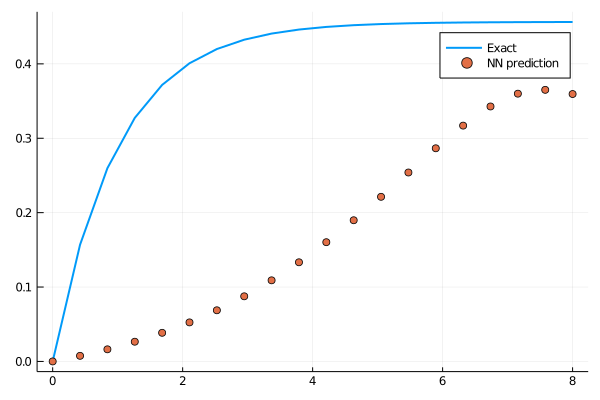

loss: 104:   0%|▎                                        |  ETA: 2:29:33

30.47616f0

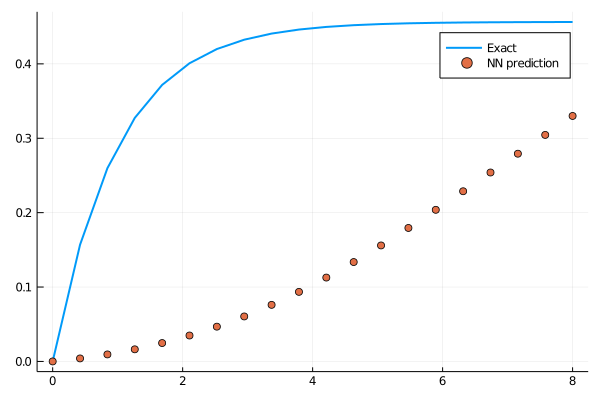

loss: 30.5:   1%|▍                                        |  ETA: 1:16:02

20.003914f0

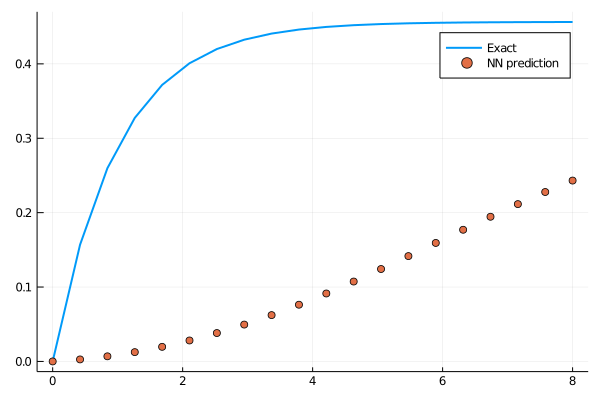

loss: 20:   2%|▋                                        |  ETA: 0:50:45

15.315334f0

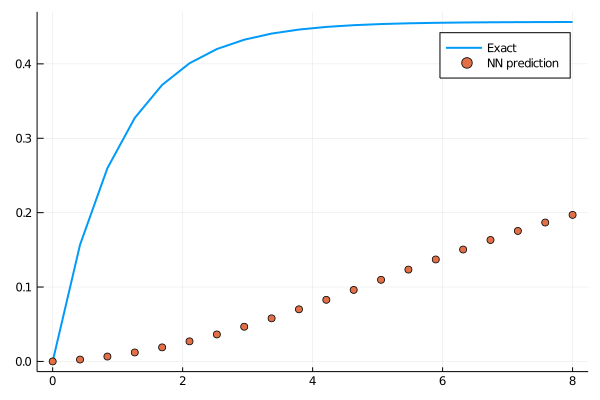

loss: 15.3:   2%|▉                                        |  ETA: 0:38:02

12.936119f0

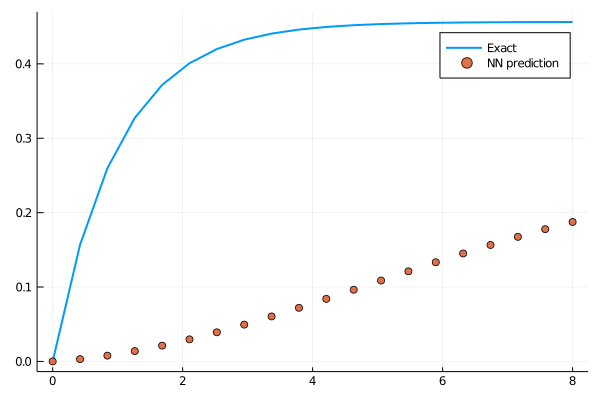

loss: 12.9:   2%|█                                        |  ETA: 0:30:24

12.036754f0

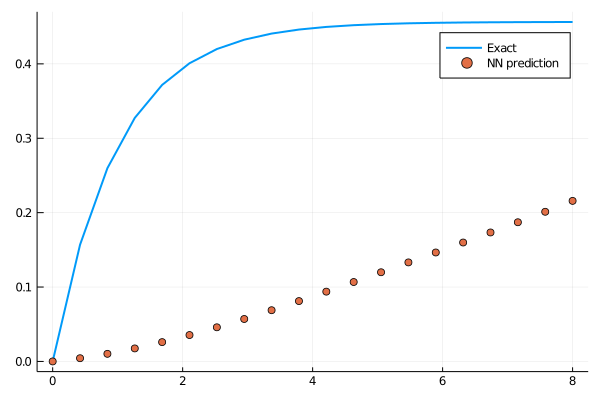

loss: 12:   3%|█▎                                       |  ETA: 0:25:21

12.1218195f0

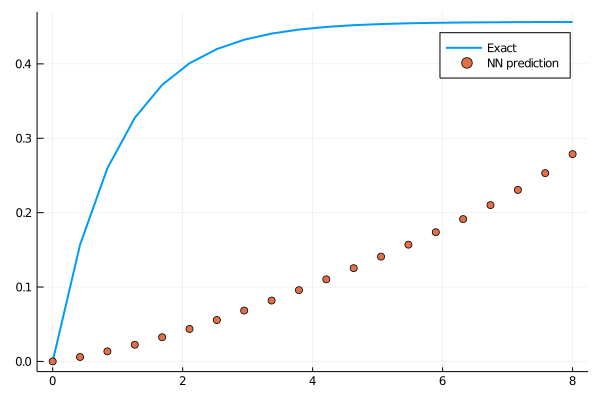

loss: 12.1:   4%|█▍                                       |  ETA: 0:21:44

12.459785f0

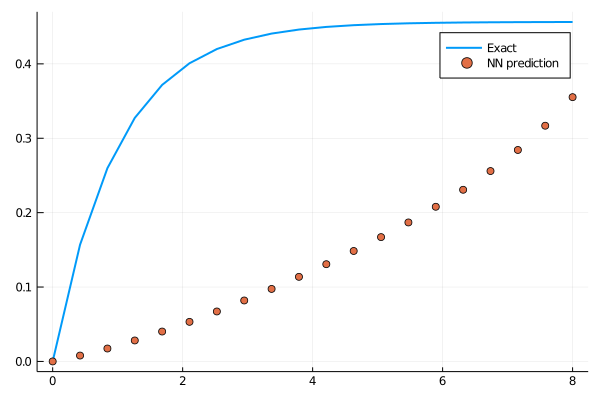

loss: 12.5:   4%|█▋                                       |  ETA: 0:19:00

12.410091f0

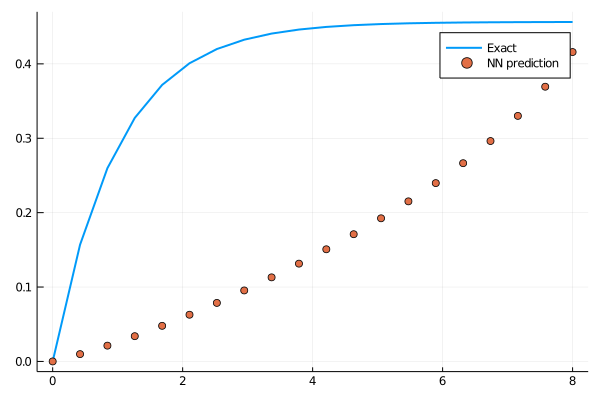

loss: 12.4:   4%|█▉                                       |  ETA: 0:16:53

11.855742f0

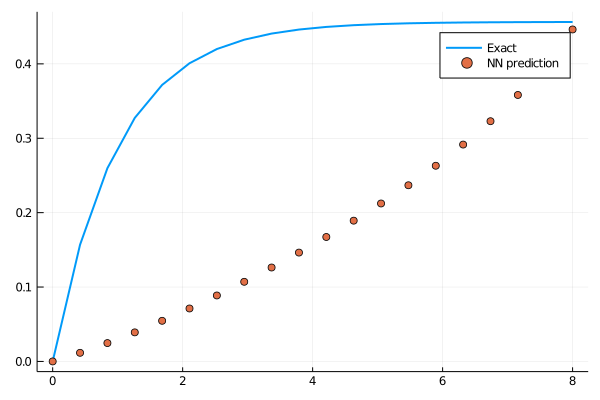

loss: 11.9:   5%|██                                       |  ETA: 0:15:11

11.080454f0

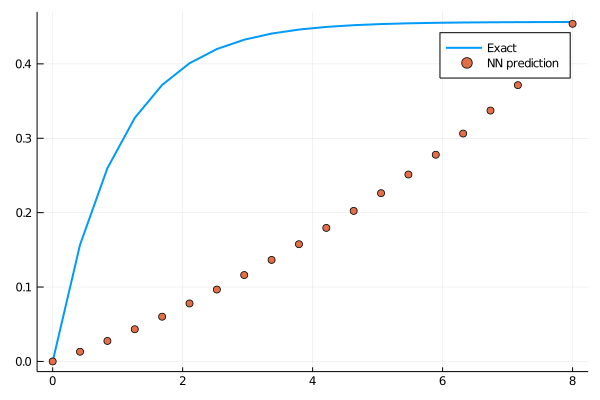

loss: 11.1:   6%|██▎                                      |  ETA: 0:13:47

10.357454f0

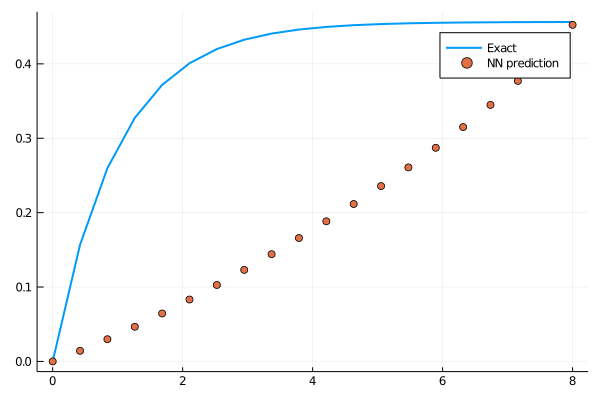

loss: 10.4:   6%|██▌                                      |  ETA: 0:12:38

9.778628f0

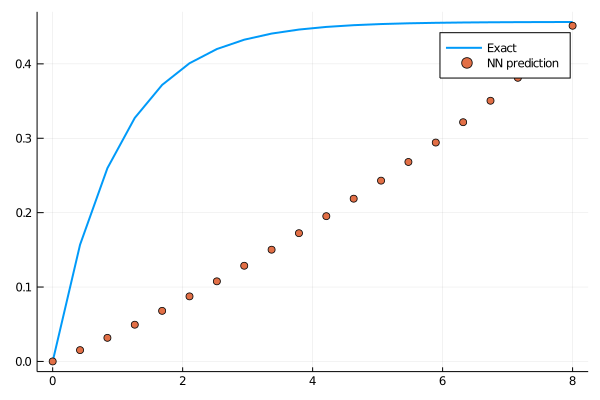

loss: 9.78:   6%|██▋                                      |  ETA: 0:11:39

9.315341f0

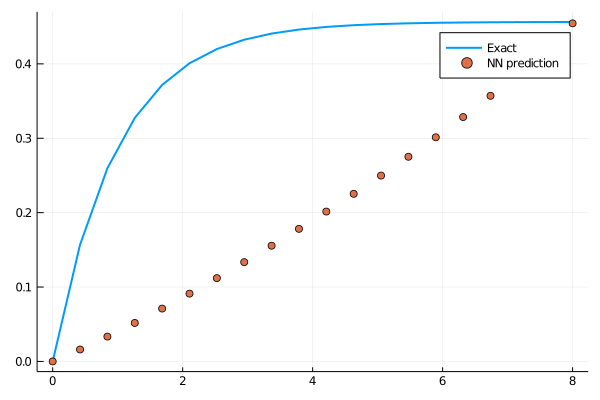

loss: 9.32:   7%|██▉                                      |  ETA: 0:10:49

8.906632f0

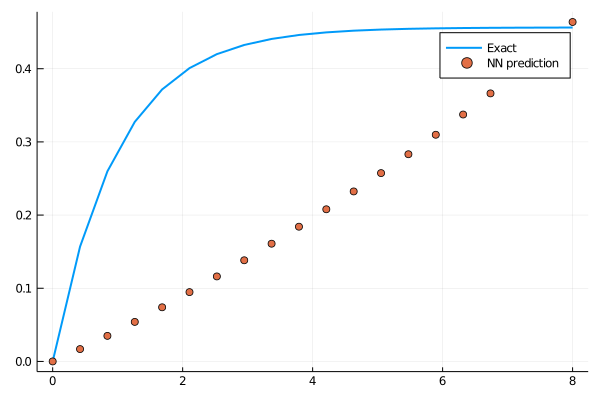

loss: 8.91:   8%|███▏                                     |  ETA: 0:10:05

8.504122f0

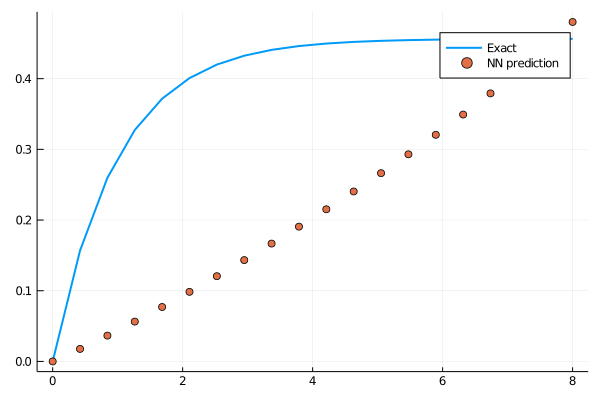

loss: 8.5:   8%|███▎                                     |  ETA: 0:09:26

8.083331f0

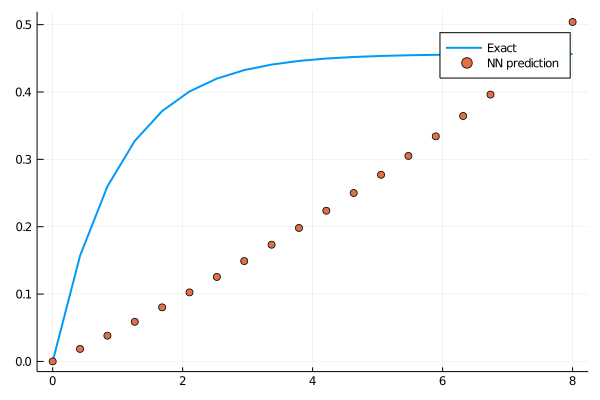

loss: 8.08:   8%|███▌                                     |  ETA: 0:08:52

7.6414285f0

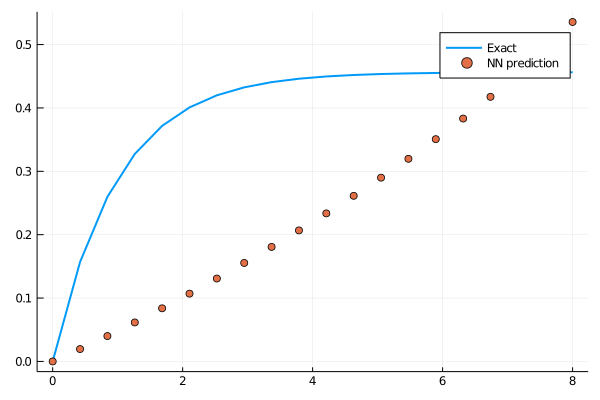

loss: 7.64:   9%|███▊                                     |  ETA: 0:08:22

7.1921387f0

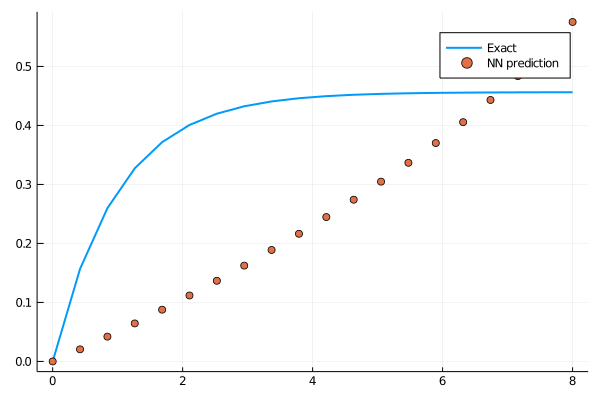

loss: 7.19:  10%|███▉                                     |  ETA: 0:07:54

6.759754f0

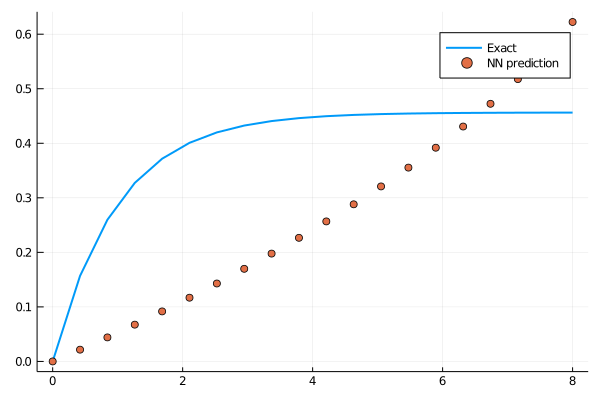

loss: 6.76:  10%|████▏                                    |  ETA: 0:07:30

6.369537f0

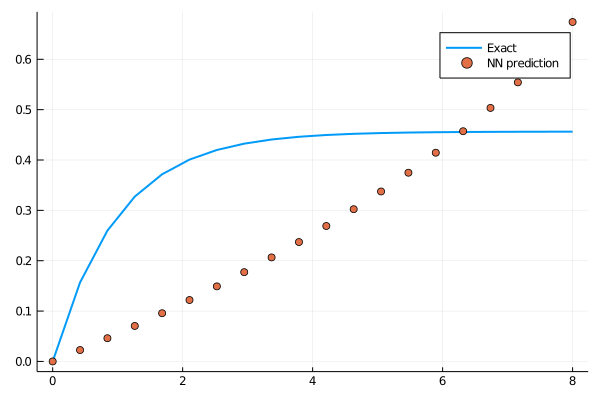

loss: 6.37:  10%|████▎                                    |  ETA: 0:07:09

6.0317087f0

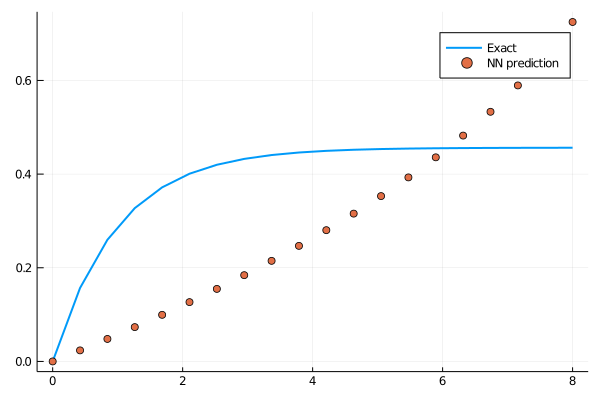

loss: 6.03:  11%|████▌                                    |  ETA: 0:06:49

5.7264786f0

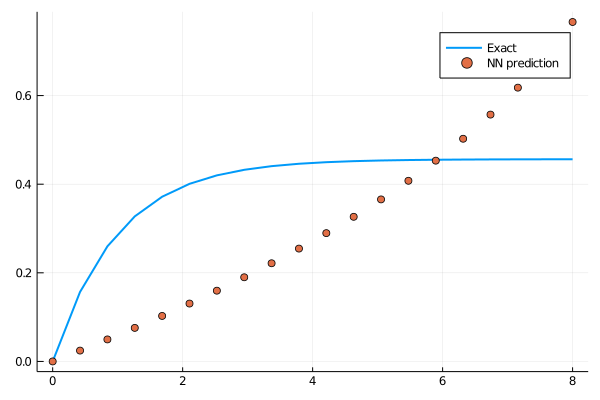

loss: 5.73:  12%|████▊                                    |  ETA: 0:06:31

5.414236f0

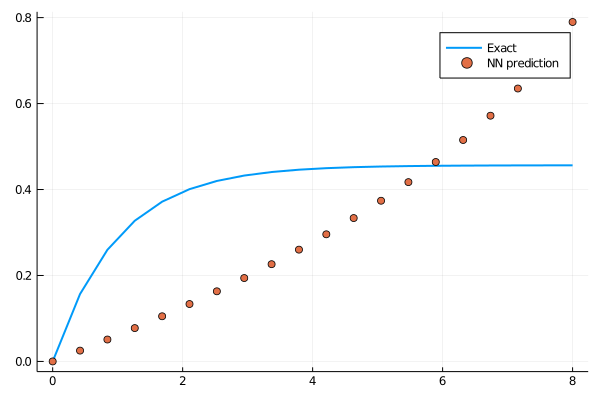

loss: 5.41:  12%|████▉                                    |  ETA: 0:06:14

5.075573f0

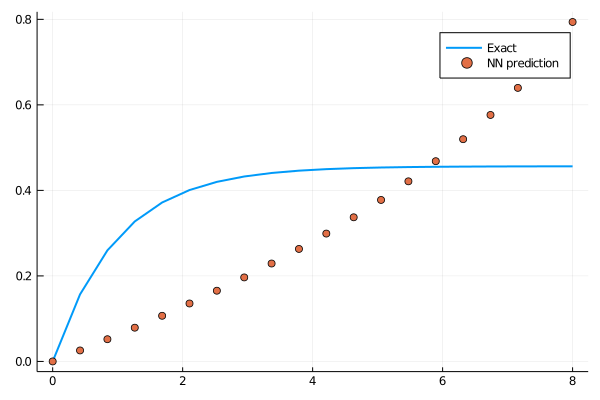

loss: 5.08:  12%|█████▏                                   |  ETA: 0:05:59

4.7298036f0

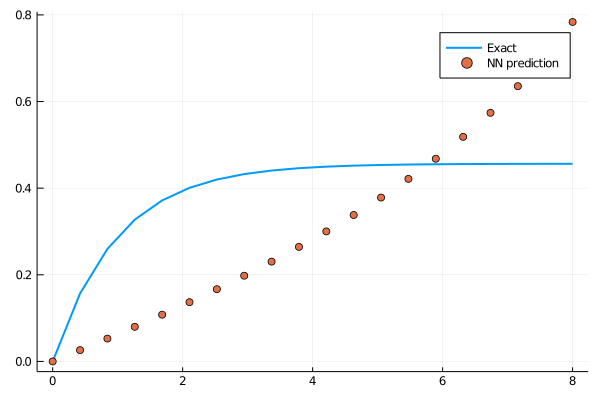

loss: 4.73:  13%|█████▍                                   |  ETA: 0:05:44

4.4063873f0

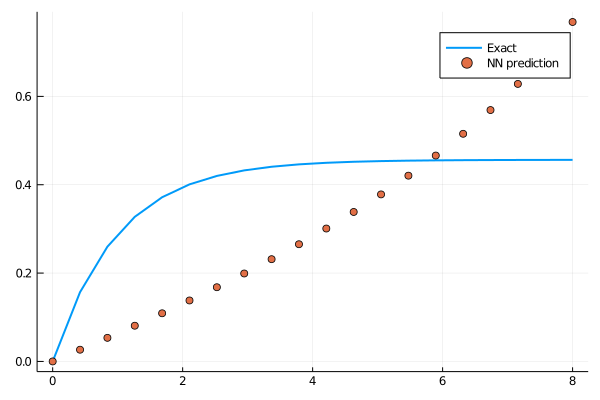

loss: 4.41:  14%|█████▌                                   |  ETA: 0:05:31

4.117429f0

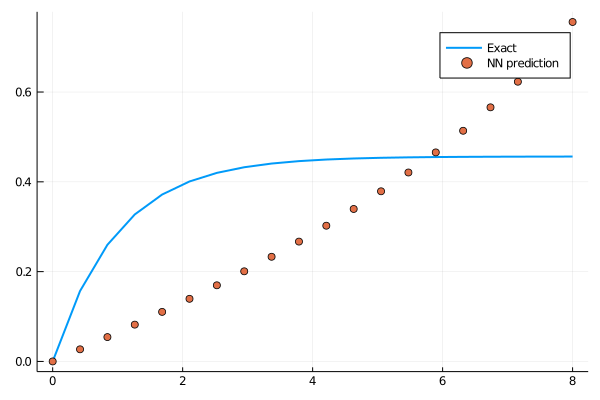

loss: 4.12:  14%|█████▊                                   |  ETA: 0:05:18

3.8603144f0

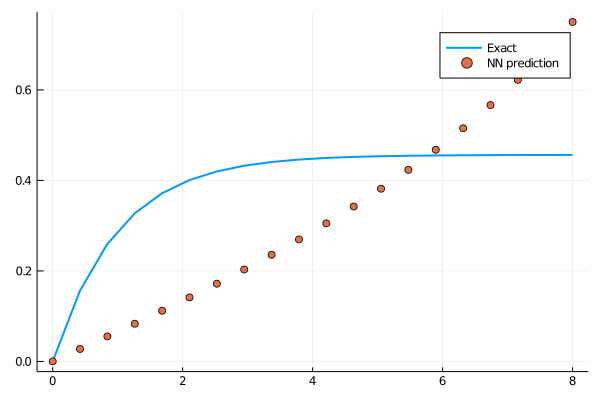

loss: 3.86:  14%|██████                                   |  ETA: 0:05:07

3.6305406f0

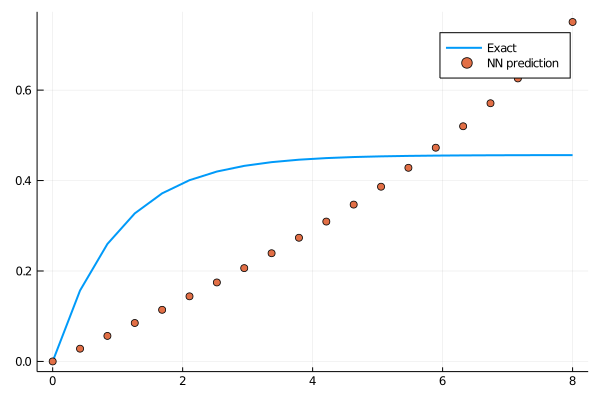

loss: 3.63:  15%|██████▏                                  |  ETA: 0:04:56

3.42537f0

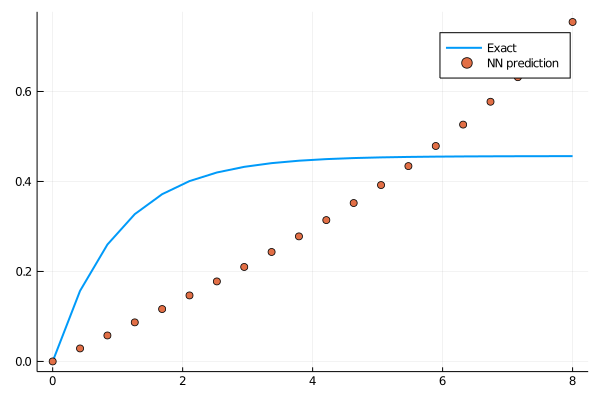

loss: 3.43:  16%|██████▍                                  |  ETA: 0:04:46

3.2392364f0

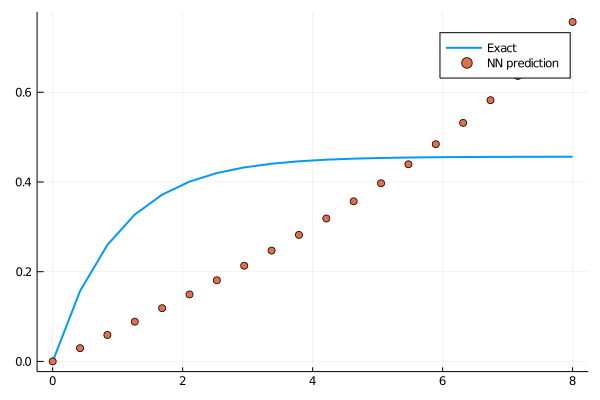

loss: 3.24:  16%|██████▌                                  |  ETA: 0:04:36

3.0617685f0

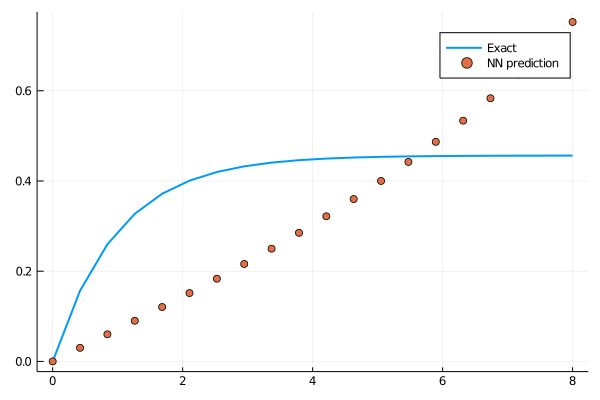

loss: 3.06:  16%|██████▊                                  |  ETA: 0:04:27

2.8843837f0

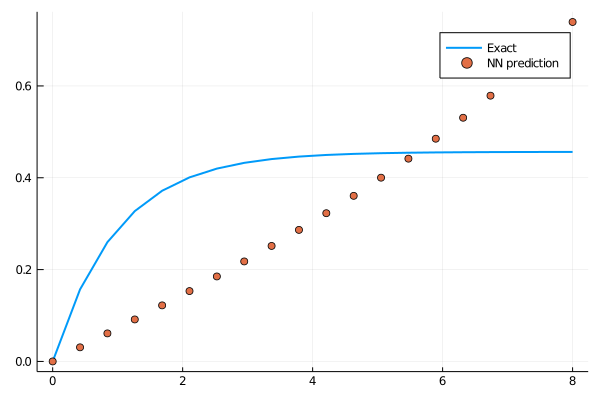

loss: 2.88:  17%|███████                                  |  ETA: 0:04:18

2.7085273f0

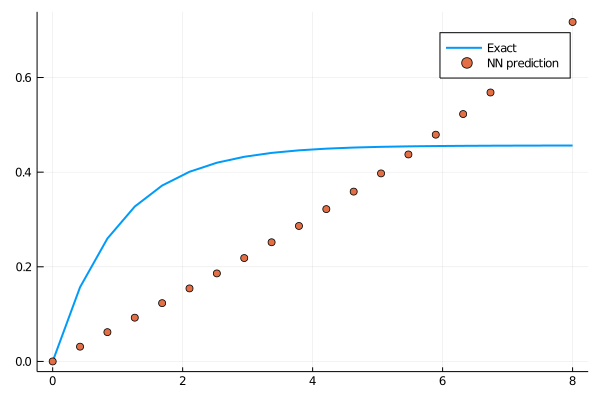

loss: 2.71:  18%|███████▏                                 |  ETA: 0:04:10

2.5443127f0

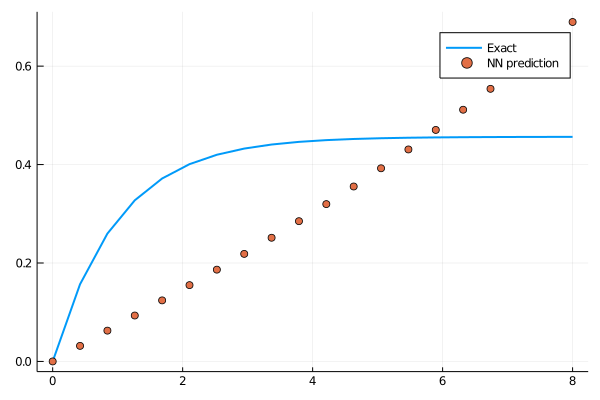

loss: 2.54:  18%|███████▍                                 |  ETA: 0:04:03

2.400523f0

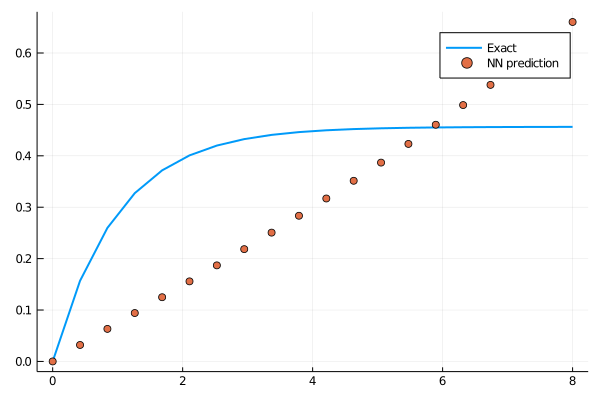

loss: 2.4:  18%|███████▋                                 |  ETA: 0:03:56

2.2772565f0

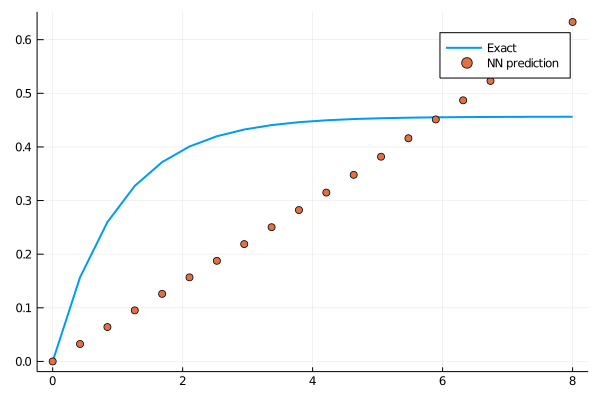

loss: 2.28:  19%|███████▊                                 |  ETA: 0:03:49

2.1675966f0

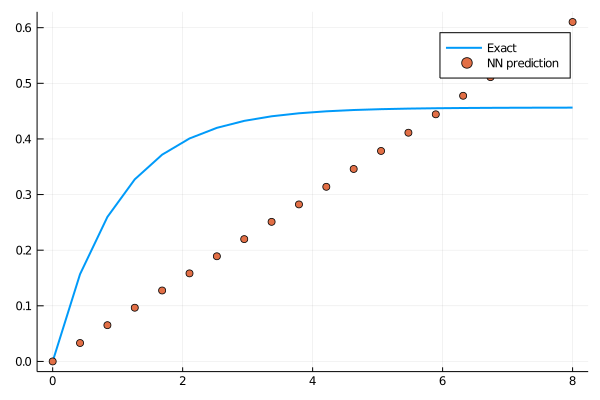

loss: 2.17:  20%|████████                                 |  ETA: 0:03:43

2.0648408f0

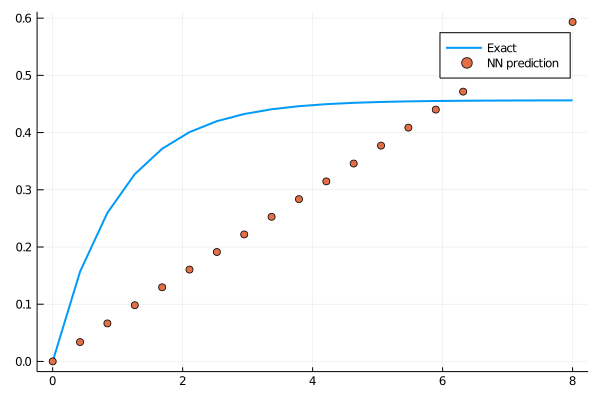

loss: 2.06:  20%|████████▎                                |  ETA: 0:03:36

1.9681021f0

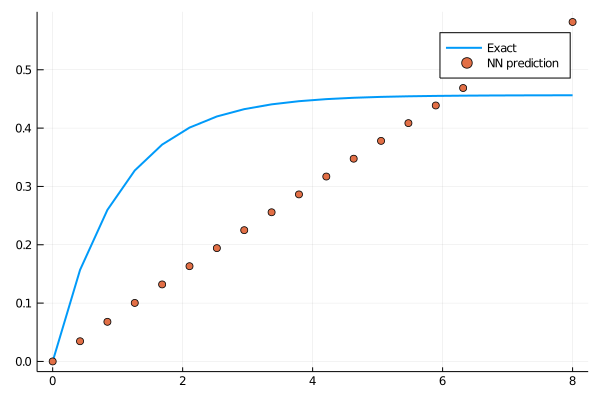

loss: 1.97:  20%|████████▍                                |  ETA: 0:03:30

1.8819379f0

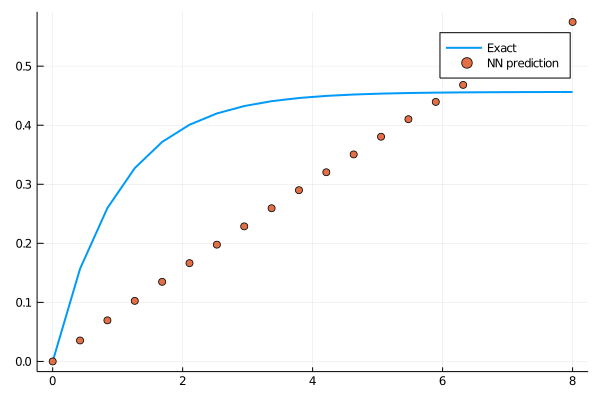

loss: 1.88:  21%|████████▋                                |  ETA: 0:03:25

1.8109609f0

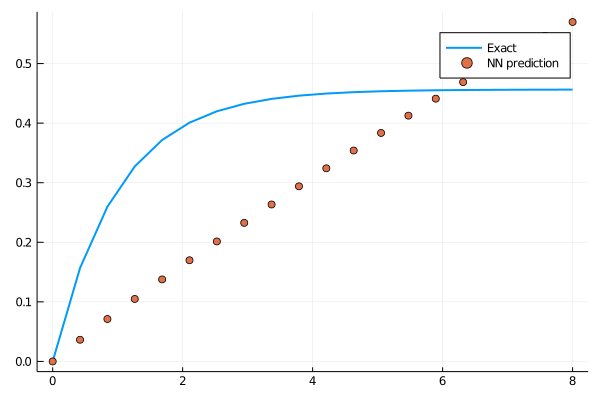

loss: 1.81:  22%|████████▉                                |  ETA: 0:03:20

1.7545102f0

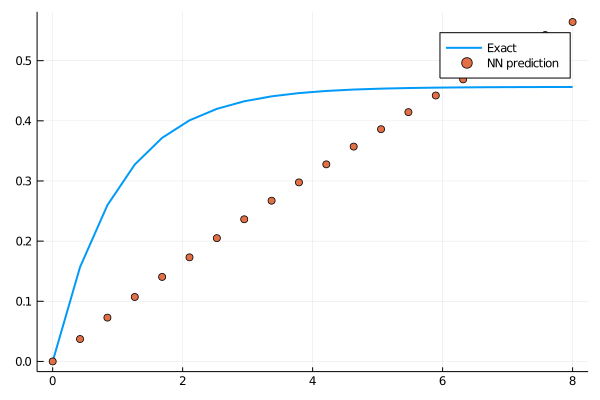

loss: 1.75:  22%|█████████                                |  ETA: 0:03:14

1.7066284f0

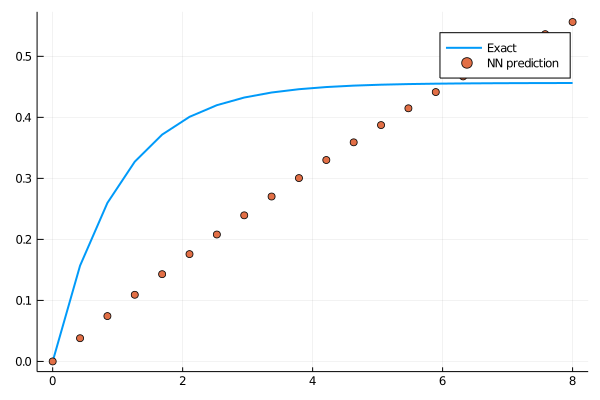

loss: 1.71:  22%|█████████▎                               |  ETA: 0:03:09

1.6615375f0

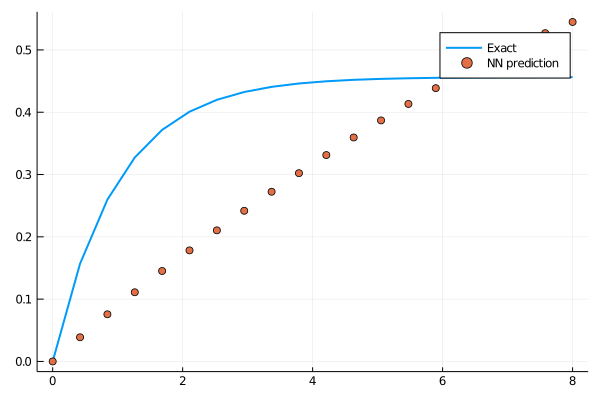

loss: 1.66:  23%|█████████▍                               |  ETA: 0:03:05

1.6185004f0

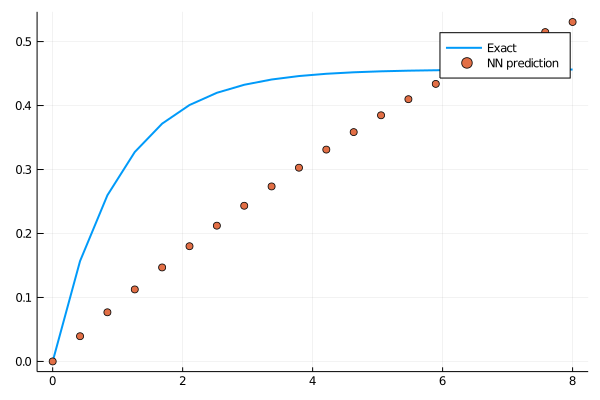

loss: 1.62:  24%|█████████▋                               |  ETA: 0:03:00

1.5806022f0

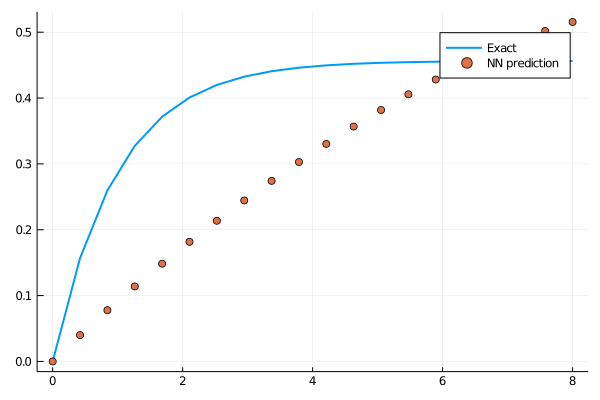

loss: 1.58:  24%|█████████▉                               |  ETA: 0:02:56

1.5493835f0

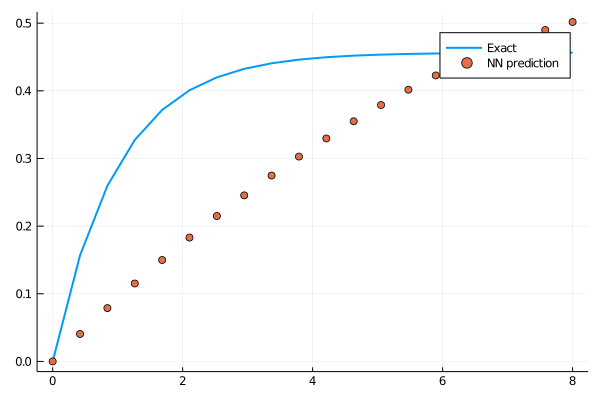

loss: 1.55:  24%|██████████                               |  ETA: 0:02:52

1.5216962f0

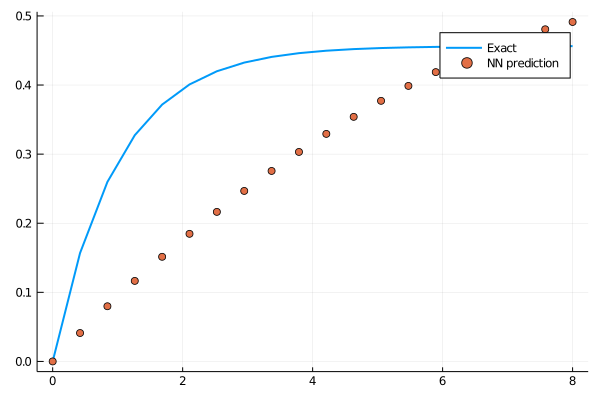

loss: 1.52:  25%|██████████▎                              |  ETA: 0:02:48

1.4919617f0

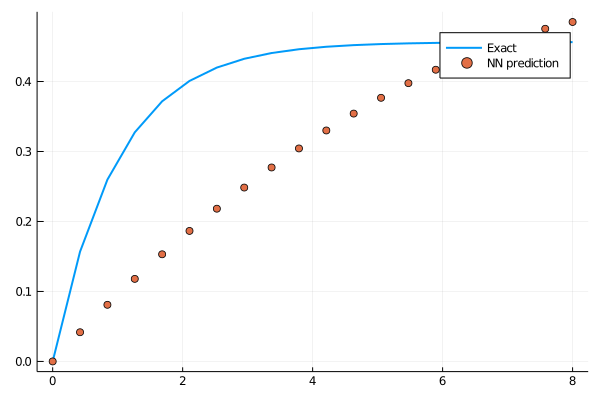

loss: 1.49:  26%|██████████▌                              |  ETA: 0:02:44

1.4569786f0

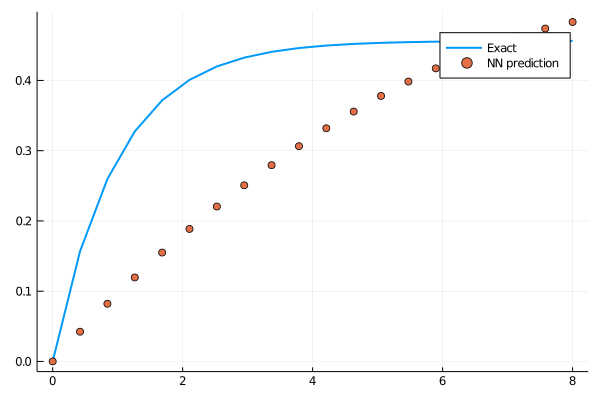

loss: 1.46:  26%|██████████▋                              |  ETA: 0:02:40

1.4179605f0

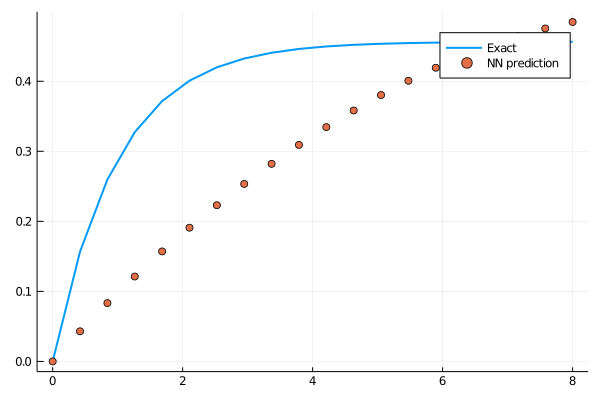

loss: 1.42:  26%|██████████▉                              |  ETA: 0:02:36

1.3778487f0

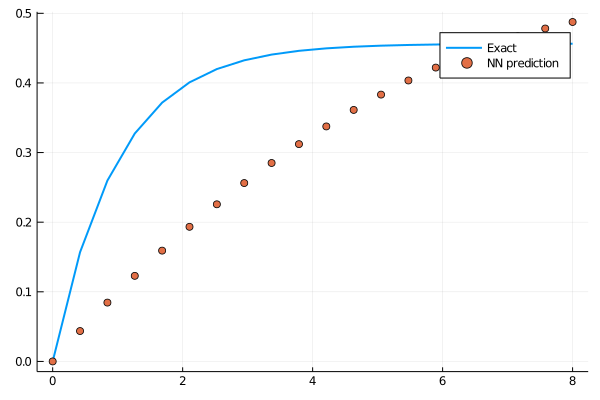

loss: 1.38:  27%|███████████▏                             |  ETA: 0:02:33

1.3375599f0

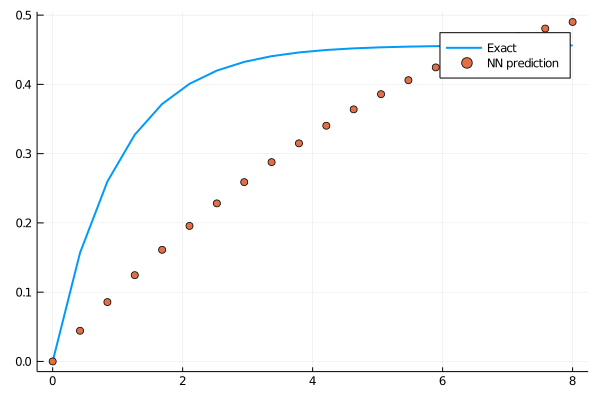

loss: 1.34:  28%|███████████▎                             |  ETA: 0:02:30

1.2959104f0

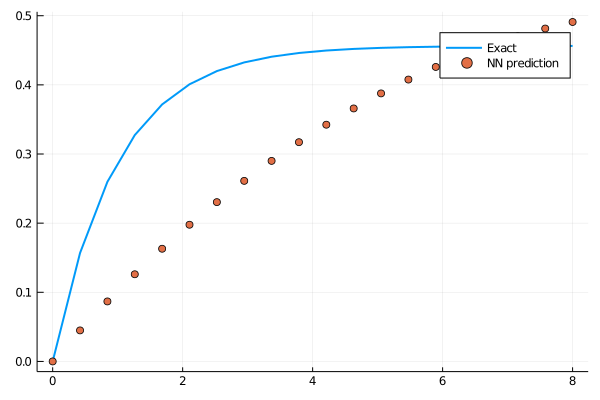

loss: 1.3:  28%|███████████▌                             |  ETA: 0:02:26

1.2527369f0

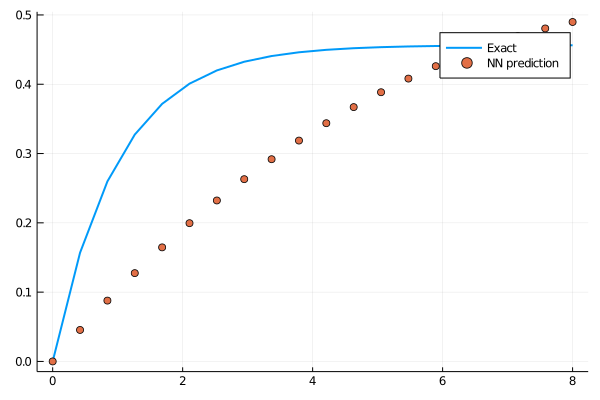

loss: 1.25:  28%|███████████▋                             |  ETA: 0:02:23

1.2102406f0

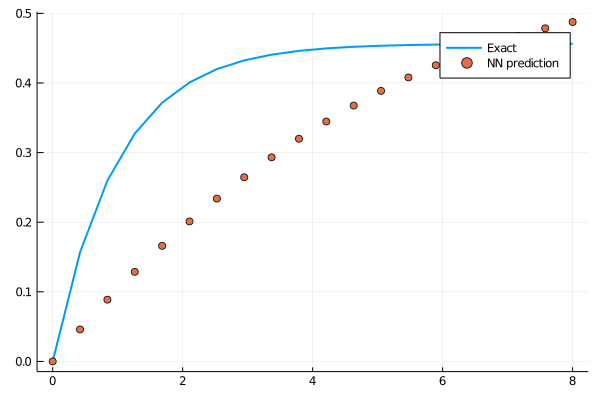

loss: 1.21:  29%|███████████▉                             |  ETA: 0:02:20

1.1706381f0

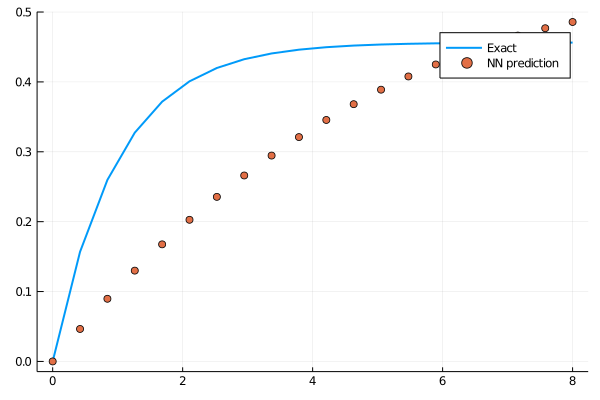

loss: 1.17:  30%|████████████▏                            |  ETA: 0:02:17

1.1337763f0

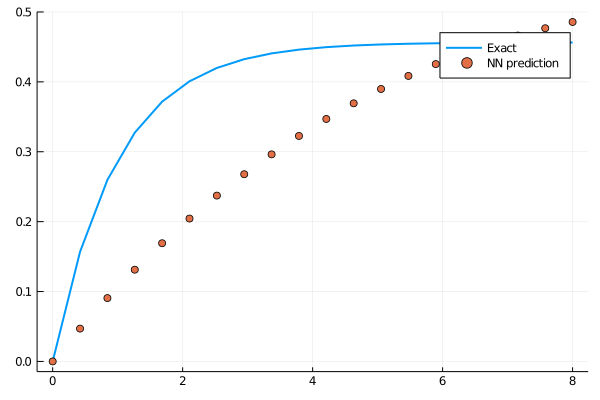

loss: 1.13:  30%|████████████▎                            |  ETA: 0:02:15

1.0979273f0

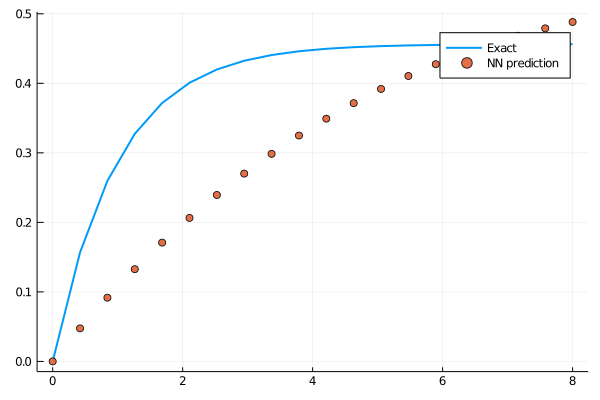

loss: 1.1:  30%|████████████▌                            |  ETA: 0:02:12

1.0622172f0

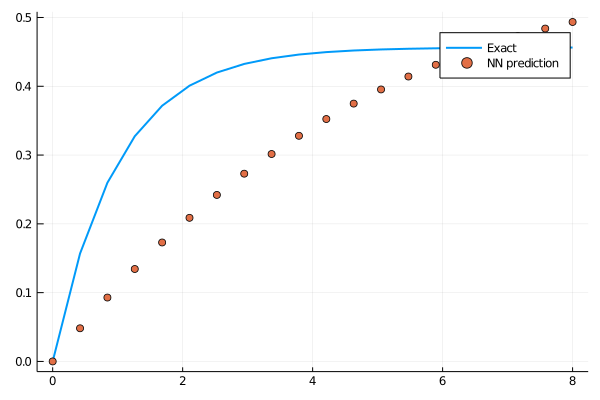

loss: 1.06:  31%|████████████▊                            |  ETA: 0:02:09

1.0273579f0

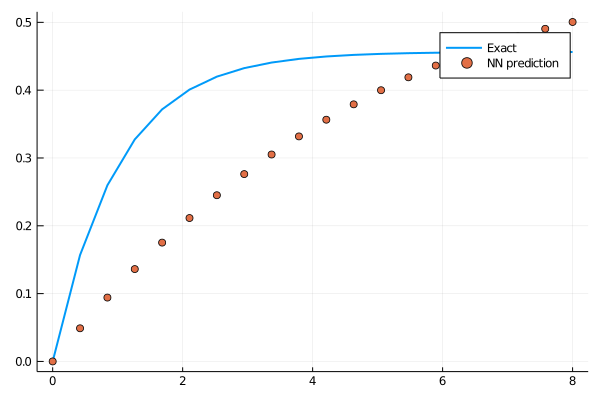

loss: 1.03:  32%|████████████▉                            |  ETA: 0:02:07

0.99412423f0

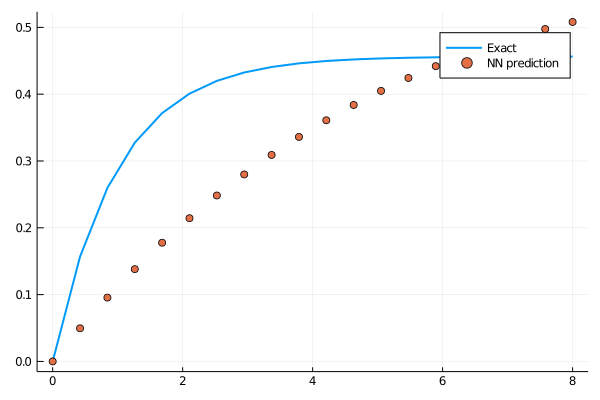

loss: 0.994:  32%|█████████████▏                           |  ETA: 0:02:04

0.9620074f0

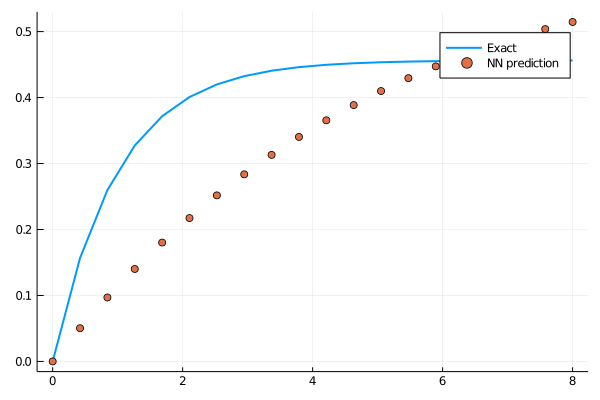

loss: 0.962:  32%|█████████████▍                           |  ETA: 0:02:01

0.92994976f0

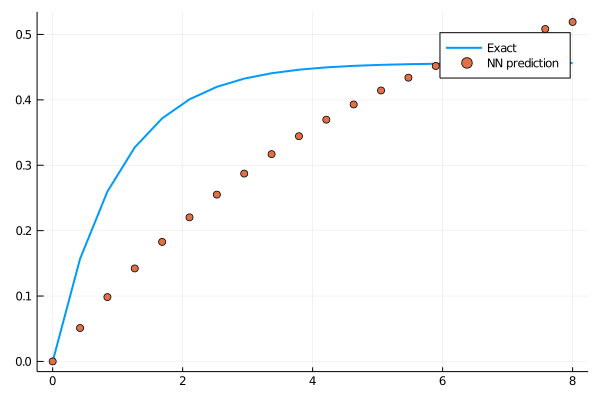

loss: 0.93:  33%|█████████████▌                           |  ETA: 0:01:59

0.8979752f0

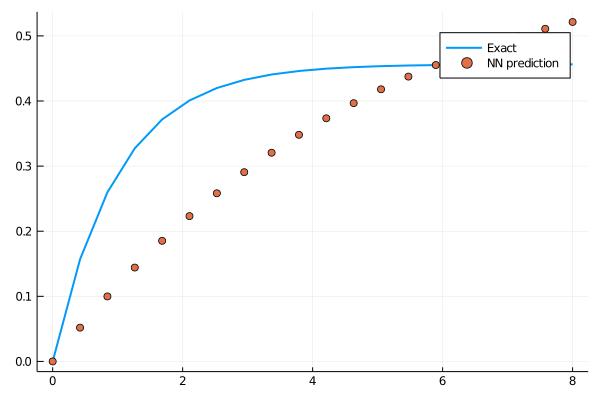

loss: 0.898:  34%|█████████████▊                           |  ETA: 0:01:57

0.8672735f0

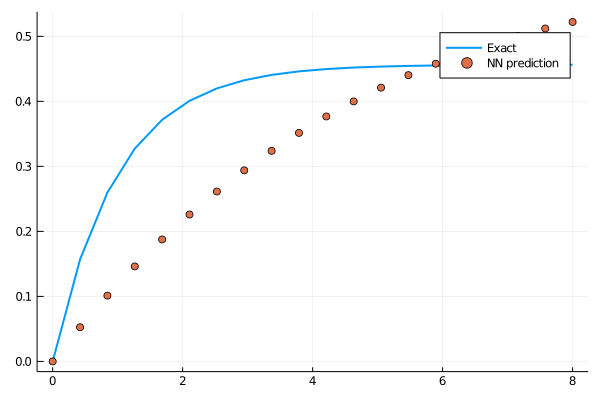

loss: 0.867:  34%|██████████████                           |  ETA: 0:01:54

0.8387003f0

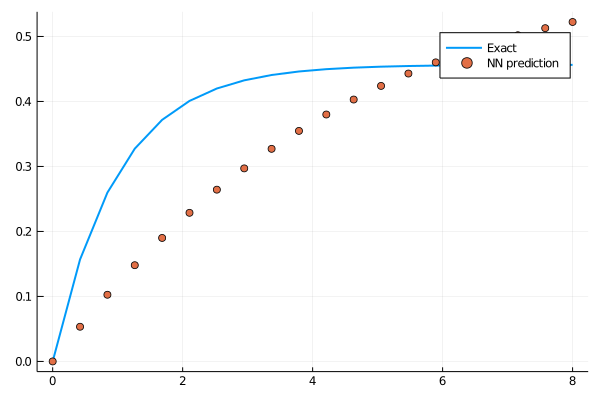

loss: 0.839:  34%|██████████████▏                          |  ETA: 0:01:52

0.8119804f0

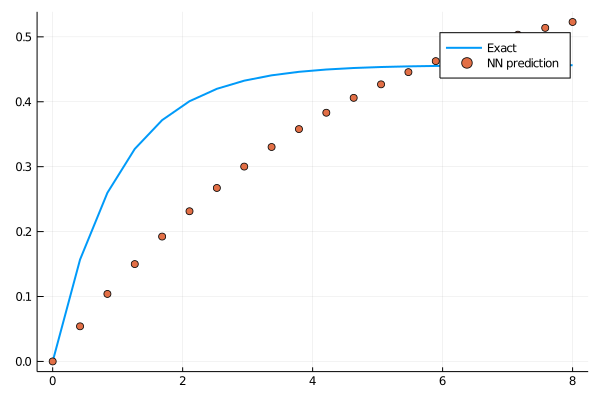

loss: 0.812:  35%|██████████████▍                          |  ETA: 0:01:50

0.7865601f0

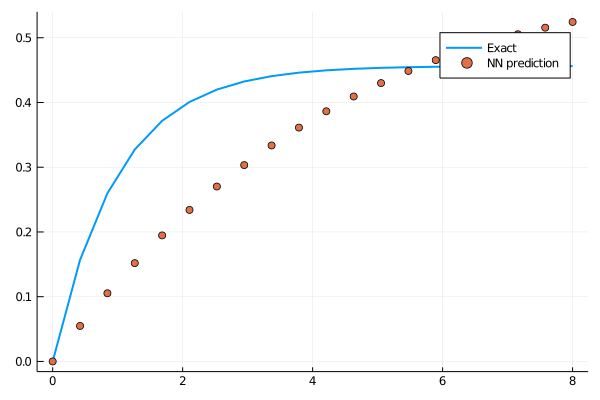

loss: 0.787:  36%|██████████████▌                          |  ETA: 0:01:48

0.76249444f0

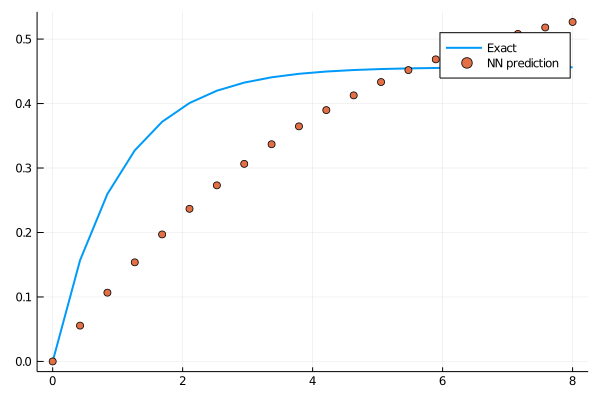

loss: 0.762:  36%|██████████████▊                          |  ETA: 0:01:46

0.74000806f0

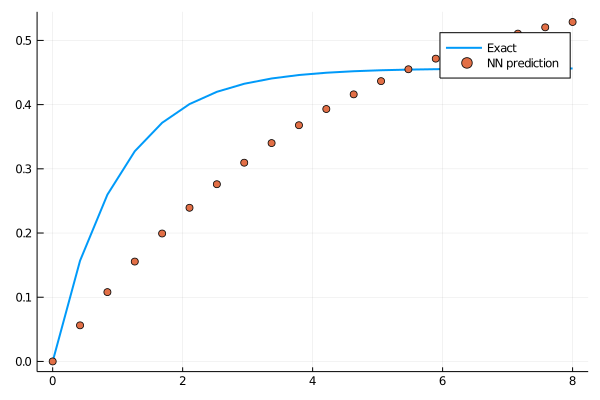

loss: 0.74:  36%|███████████████                          |  ETA: 0:01:44

0.7187194f0

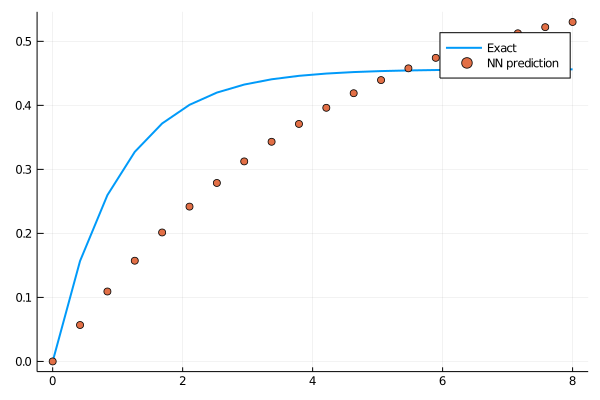

loss: 0.719:  37%|███████████████▏                         |  ETA: 0:01:42

0.6979843f0

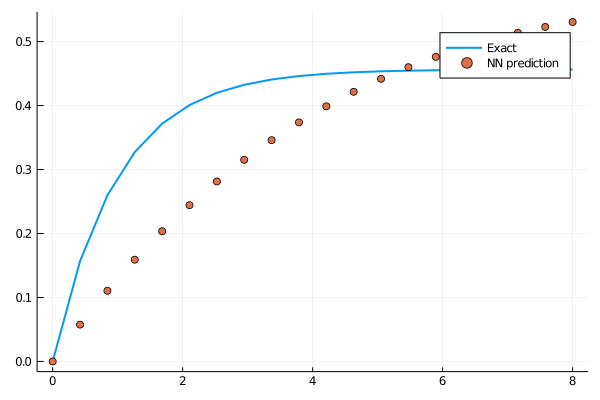

loss: 0.698:  38%|███████████████▍                         |  ETA: 0:01:40

0.6778026f0

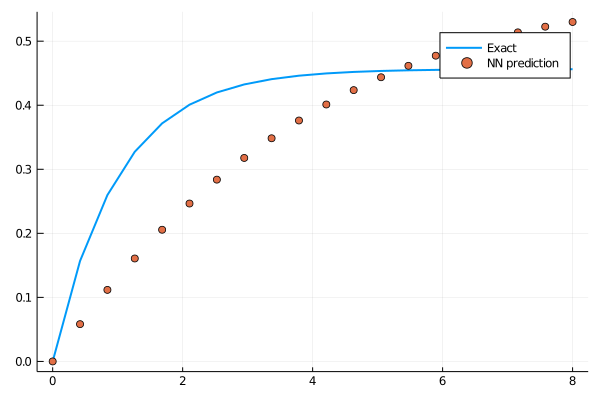

loss: 0.678:  38%|███████████████▋                         |  ETA: 0:01:38

0.65871507f0

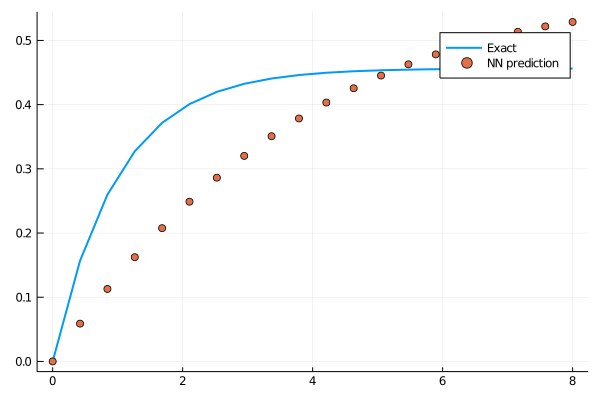

loss: 0.659:  38%|███████████████▊                         |  ETA: 0:01:37

0.64085144f0

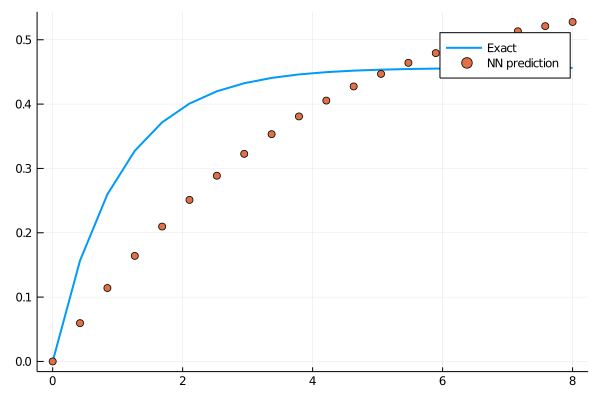

loss: 0.641:  39%|████████████████                         |  ETA: 0:01:35

0.62371534f0

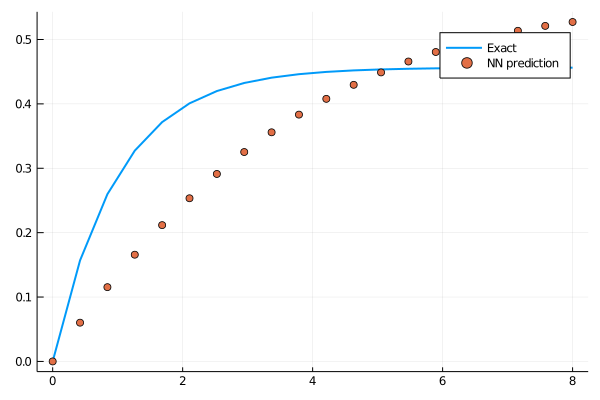

loss: 0.624:  40%|████████████████▎                        |  ETA: 0:01:33

0.6069683f0

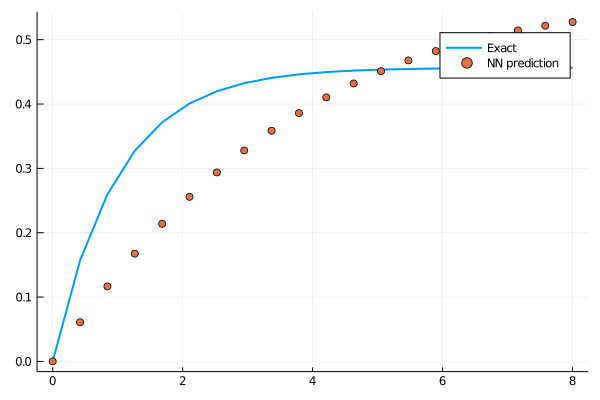

loss: 0.607:  40%|████████████████▍                        |  ETA: 0:01:32

0.5908185f0

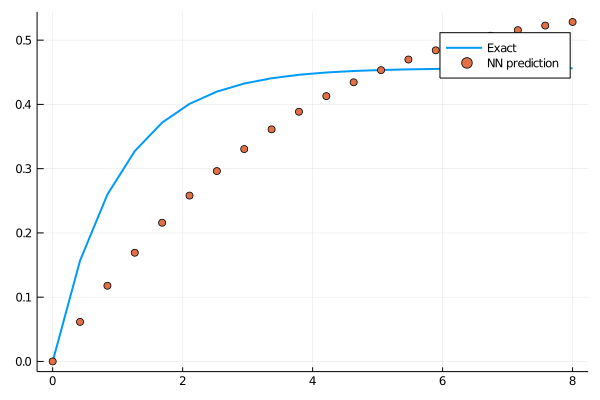

loss: 0.591:  40%|████████████████▋                        |  ETA: 0:01:30

0.5754818f0

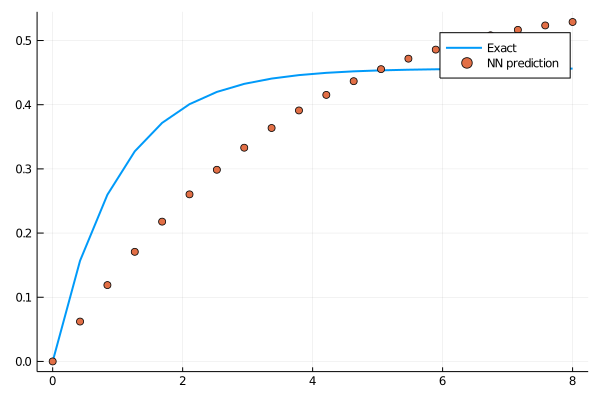

loss: 0.575:  41%|████████████████▊                        |  ETA: 0:01:28

0.56081665f0

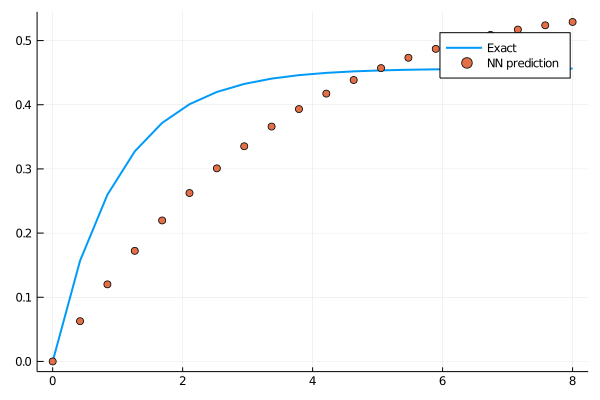

loss: 0.561:  42%|█████████████████                        |  ETA: 0:01:27

0.54668504f0

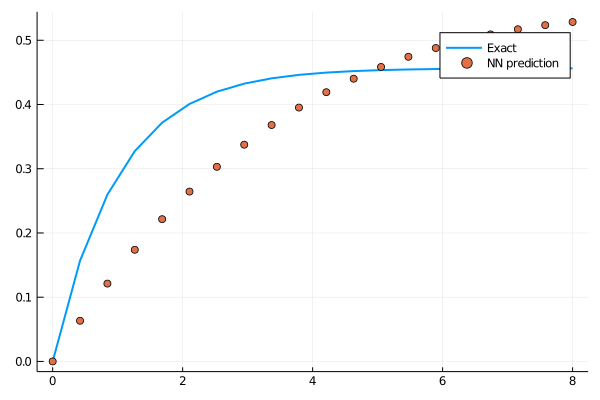

loss: 0.547:  42%|█████████████████▎                       |  ETA: 0:01:25

0.53314453f0

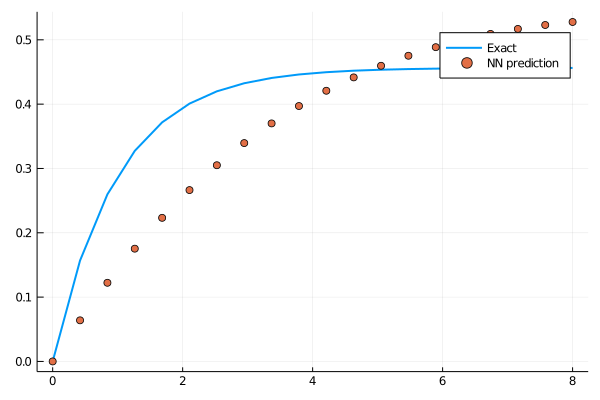

loss: 0.533:  42%|█████████████████▍                       |  ETA: 0:01:24

0.5201257f0

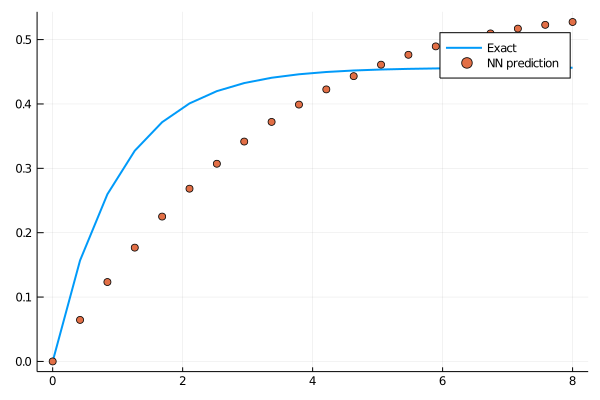

loss: 0.52:  43%|█████████████████▋                       |  ETA: 0:01:22

0.50741684f0

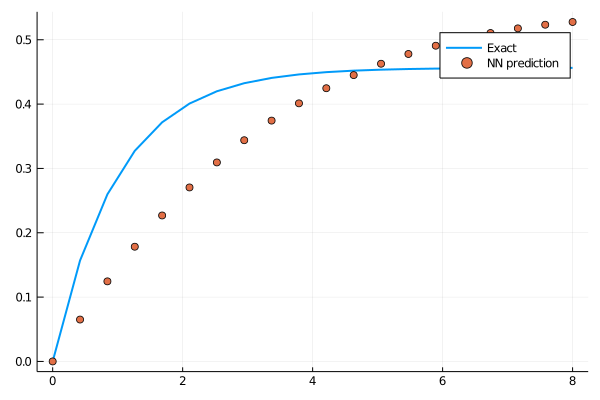

loss: 0.507:  44%|█████████████████▉                       |  ETA: 0:01:21

0.49502987f0

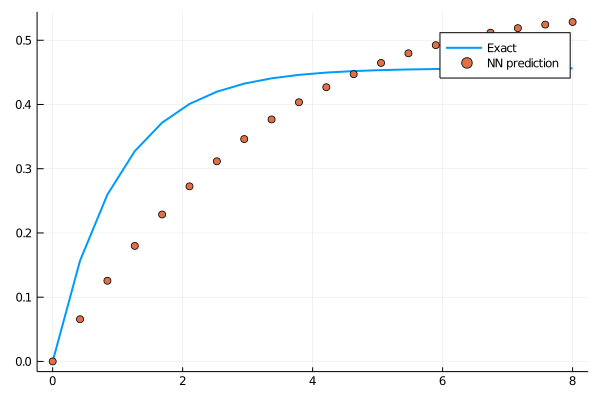

loss: 0.495:  44%|██████████████████                       |  ETA: 0:01:19

0.4831307f0

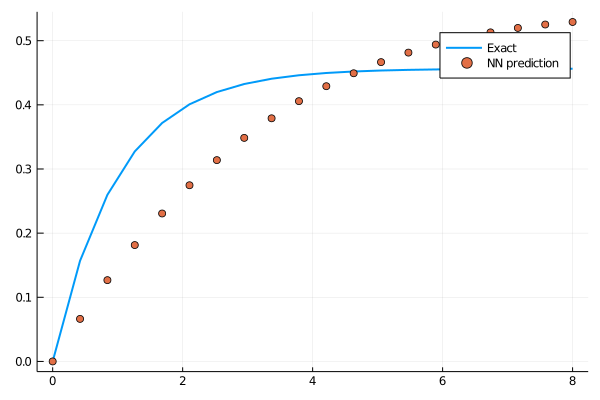

loss: 0.483:  44%|██████████████████▎                      |  ETA: 0:01:18

0.47165173f0

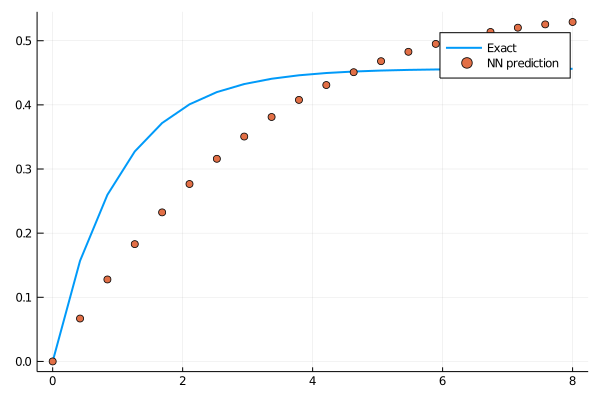

loss: 0.472:  45%|██████████████████▌                      |  ETA: 0:01:17

0.4604293f0

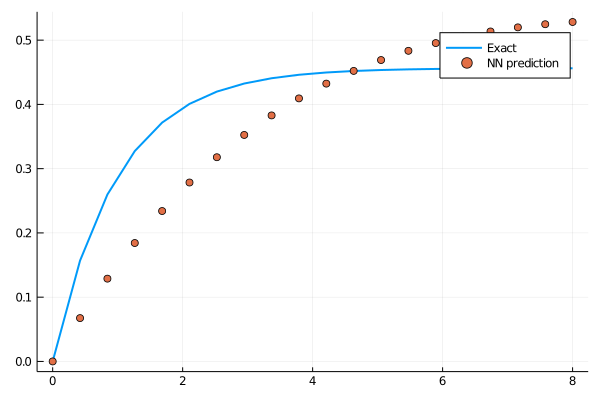

loss: 0.46:  46%|██████████████████▋                      |  ETA: 0:01:15

0.44955653f0

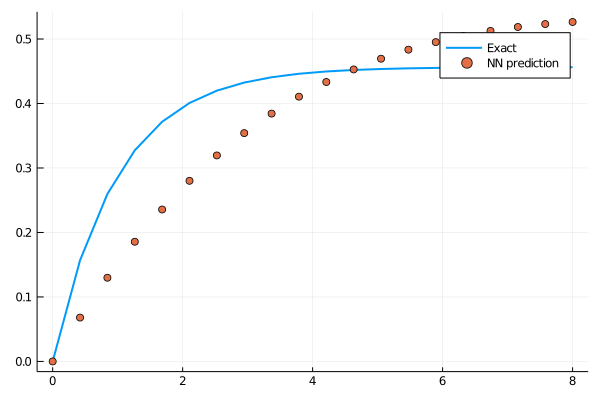

loss: 0.45:  46%|██████████████████▉                      |  ETA: 0:01:14

0.43916696f0

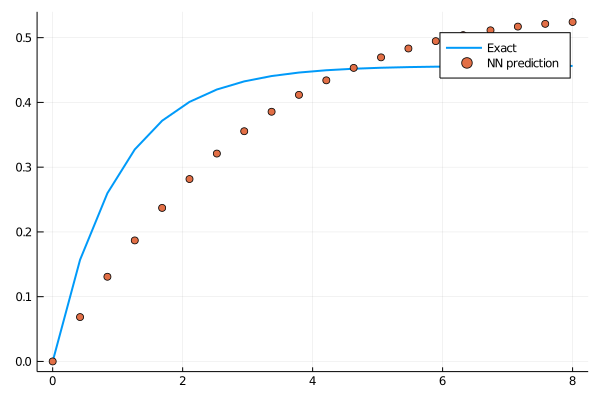

loss: 0.439:  46%|███████████████████▏                     |  ETA: 0:01:13

0.4291248f0

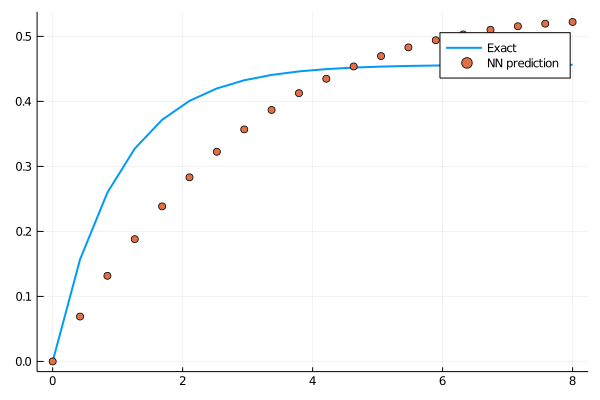

loss: 0.429:  47%|███████████████████▎                     |  ETA: 0:01:12

0.41927946f0

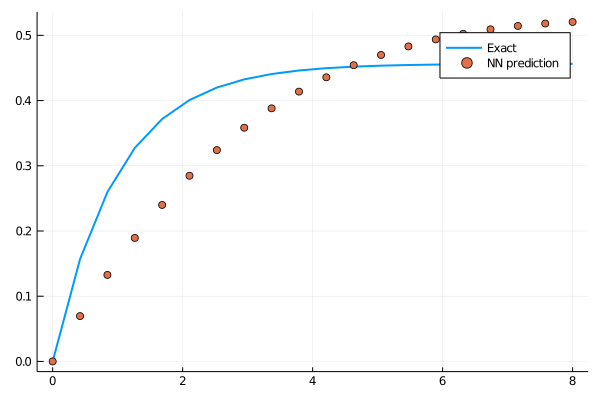

loss: 0.419:  48%|███████████████████▌                     |  ETA: 0:01:10

0.40971386f0

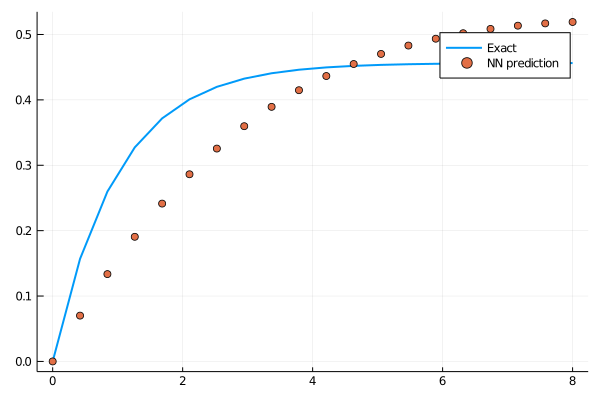

loss: 0.41:  48%|███████████████████▋                     |  ETA: 0:01:09

0.40050817f0

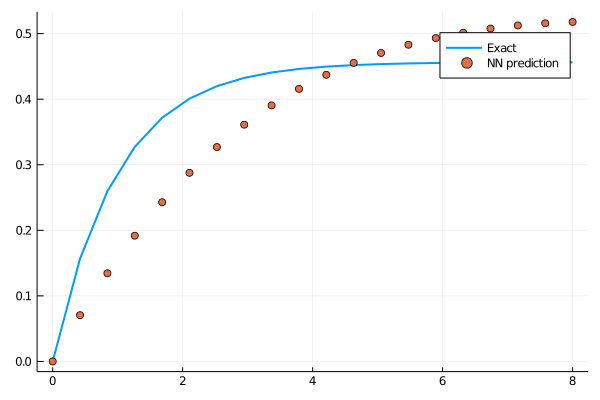

loss: 0.401:  48%|███████████████████▉                     |  ETA: 0:01:08

0.39158654f0

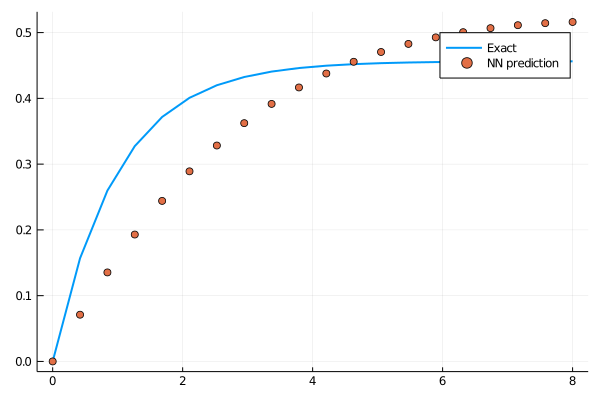

loss: 0.392:  49%|████████████████████▏                    |  ETA: 0:01:07

0.3829116f0

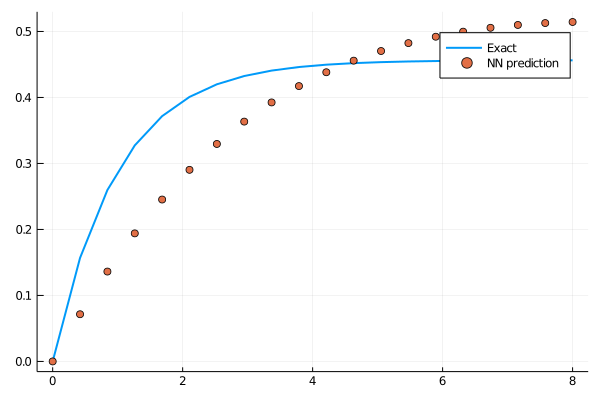

loss: 0.383:  50%|████████████████████▎                    |  ETA: 0:01:06

0.3745259f0

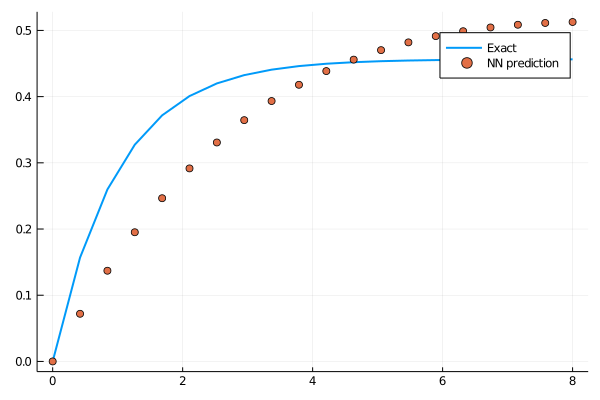

loss: 0.375:  50%|████████████████████▌                    |  ETA: 0:01:04

0.36641547f0

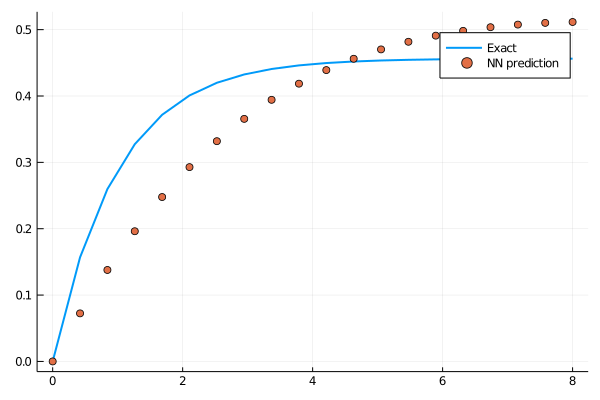

loss: 0.366:  50%|████████████████████▊                    |  ETA: 0:01:03

0.3585597f0

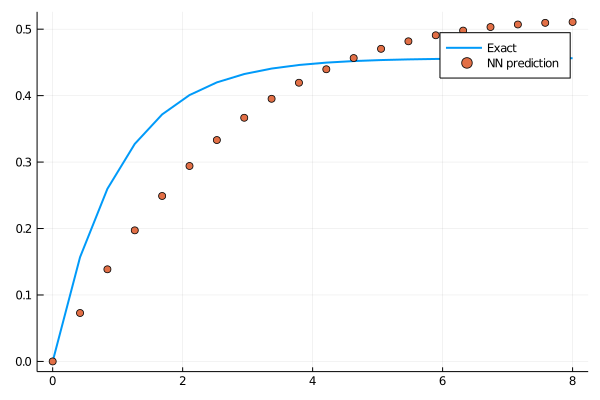

loss: 0.359:  51%|████████████████████▉                    |  ETA: 0:01:02

0.3509976f0

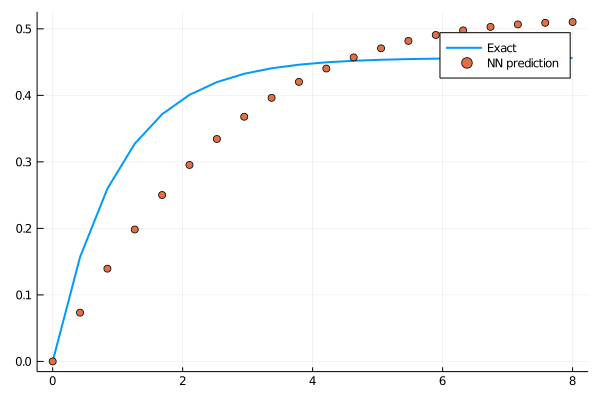

loss: 0.351:  52%|█████████████████████▏                   |  ETA: 0:01:01

0.34371924f0

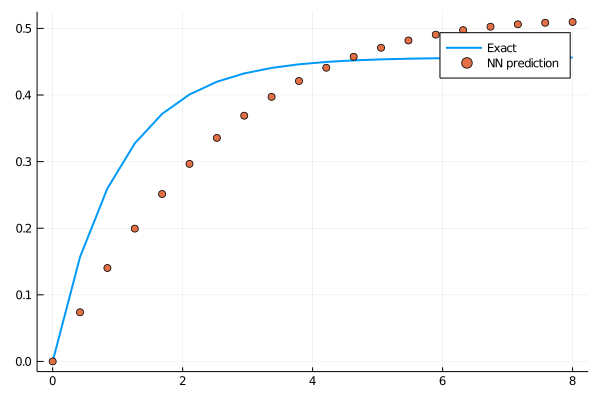

loss: 0.344:  52%|█████████████████████▍                   |  ETA: 0:01:00

0.33666834f0

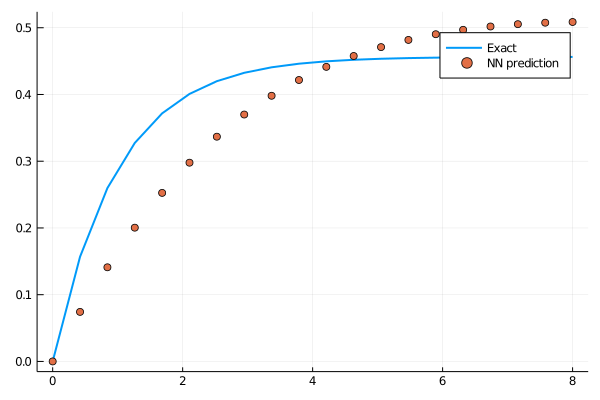

loss: 0.337:  52%|█████████████████████▌                   |  ETA: 0:00:59

0.32986307f0

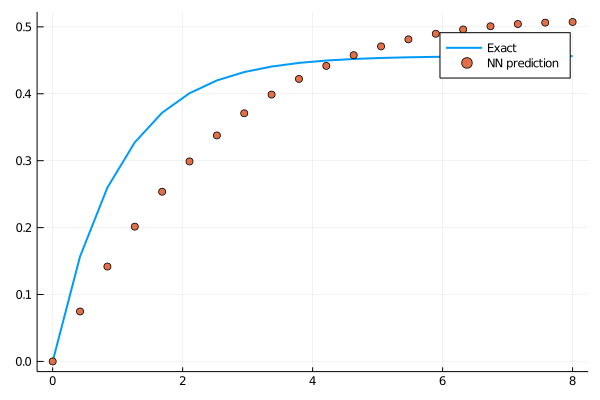

loss: 0.33:  53%|█████████████████████▊                   |  ETA: 0:00:58

0.32332858f0

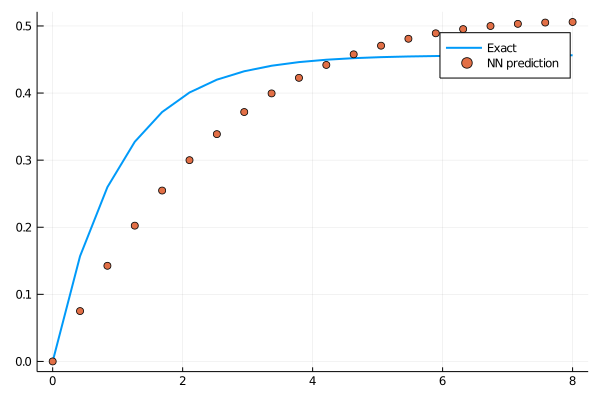

loss: 0.323:  54%|█████████████████████▉                   |  ETA: 0:00:57

0.31700754f0

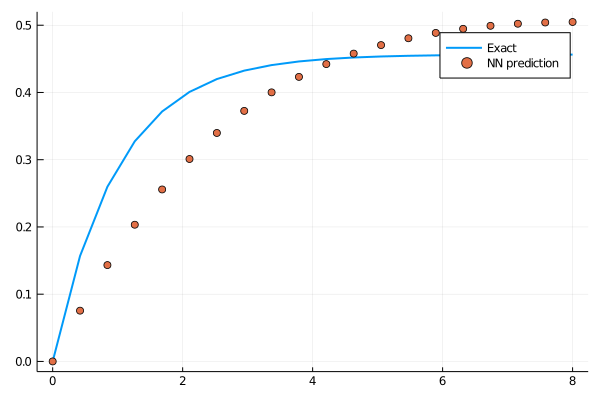

loss: 0.317:  54%|██████████████████████▏                  |  ETA: 0:00:56

0.31085977f0

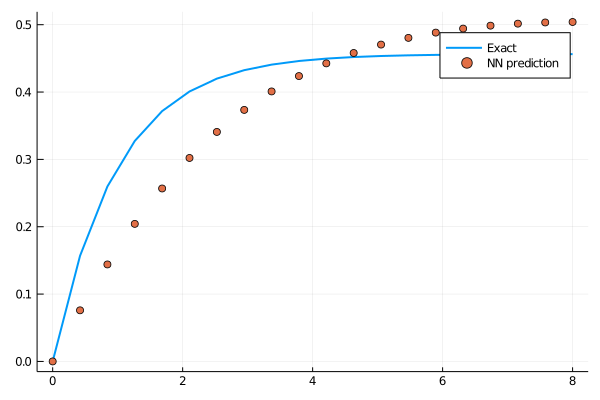

loss: 0.311:  54%|██████████████████████▍                  |  ETA: 0:00:55

0.30490434f0

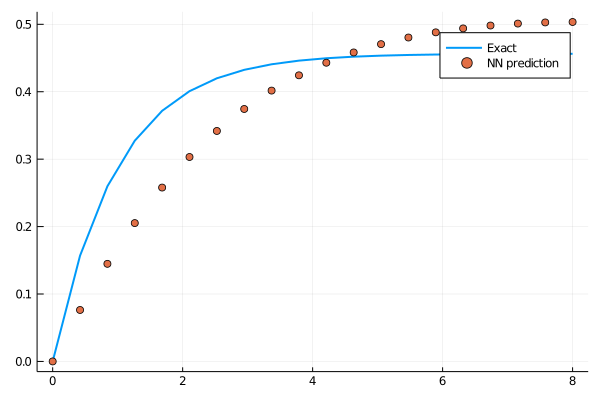

loss: 0.305:  55%|██████████████████████▌                  |  ETA: 0:00:54

0.29913488f0

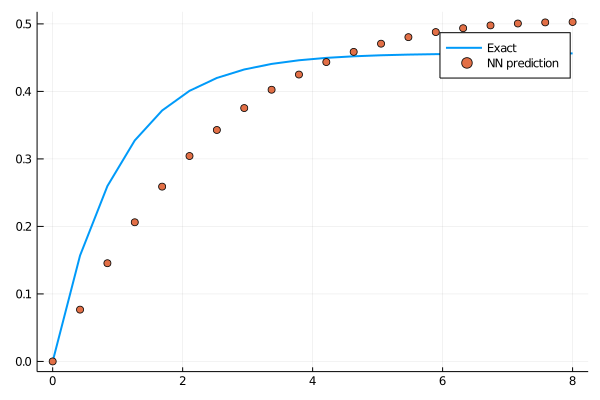

loss: 0.299:  56%|██████████████████████▊                  |  ETA: 0:00:53

0.29353383f0

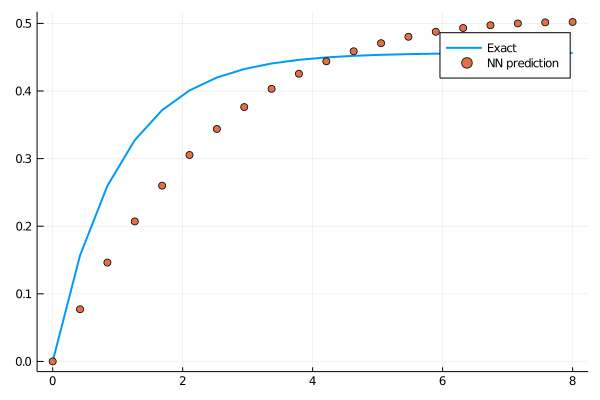

loss: 0.294:  56%|███████████████████████                  |  ETA: 0:00:52

0.2881147f0

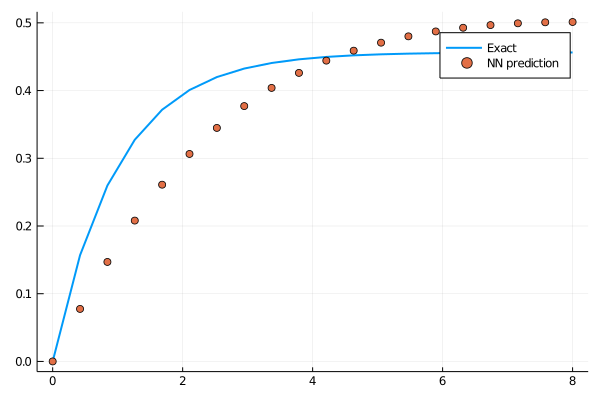

loss: 0.288:  56%|███████████████████████▏                 |  ETA: 0:00:51

0.28287154f0

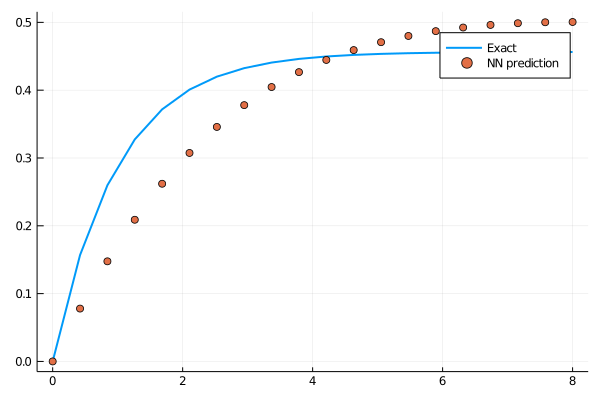

loss: 0.283:  57%|███████████████████████▍                 |  ETA: 0:00:50

0.2777701f0

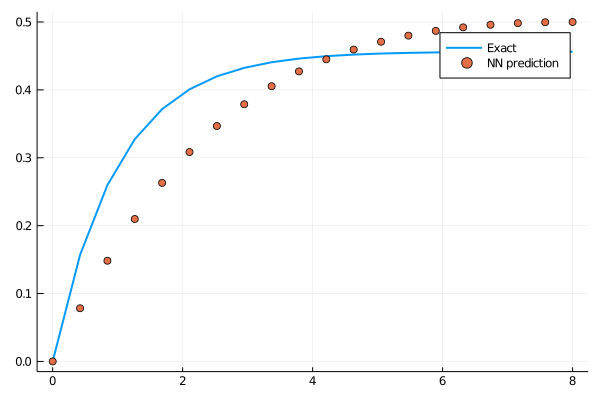

loss: 0.278:  58%|███████████████████████▋                 |  ETA: 0:00:49

0.27280504f0

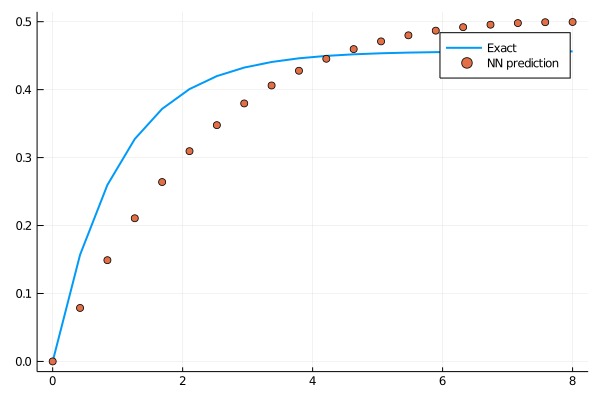

loss: 0.273:  58%|███████████████████████▊                 |  ETA: 0:00:49

0.26797962f0

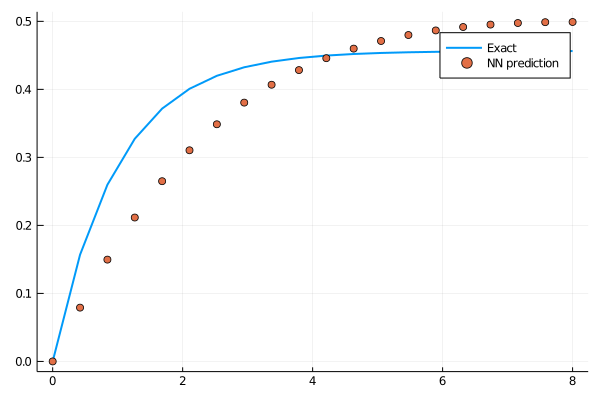

loss: 0.268:  58%|████████████████████████                 |  ETA: 0:00:48

0.26327524f0

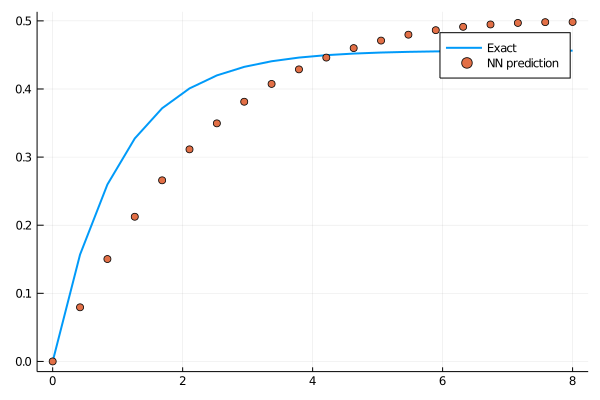

loss: 0.263:  59%|████████████████████████▎                |  ETA: 0:00:47

0.25869045f0

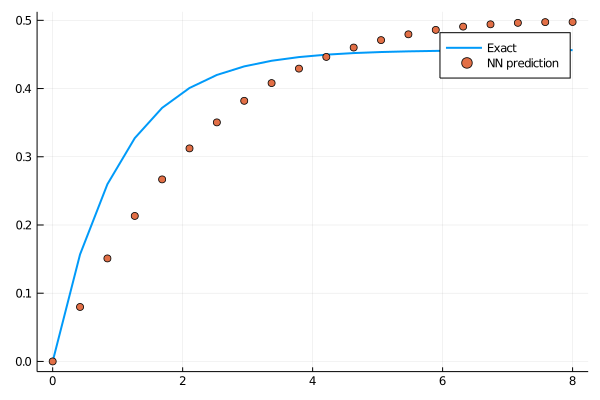

loss: 0.259:  60%|████████████████████████▍                |  ETA: 0:00:46

0.2542367f0

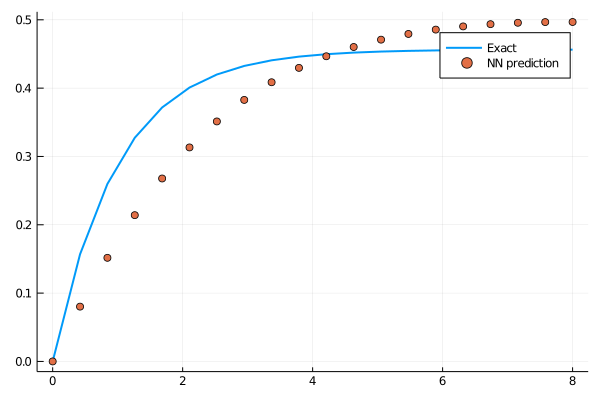

loss: 0.254:  60%|████████████████████████▋                |  ETA: 0:00:45

0.24990633f0

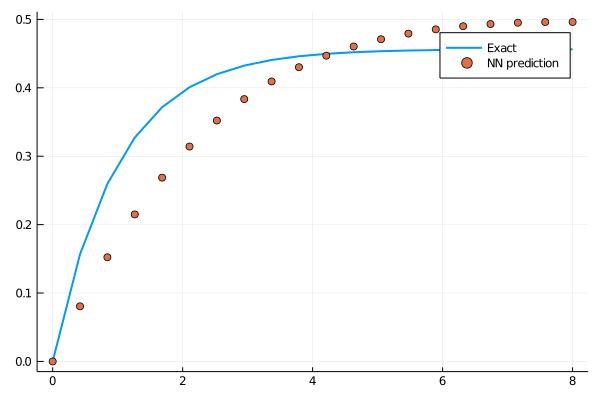

loss: 0.25:  60%|████████████████████████▊                |  ETA: 0:00:44

0.24569242f0

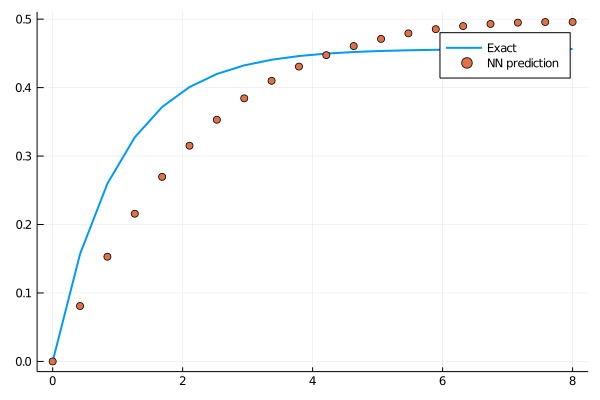

loss: 0.246:  61%|█████████████████████████                |  ETA: 0:00:43

0.24159387f0

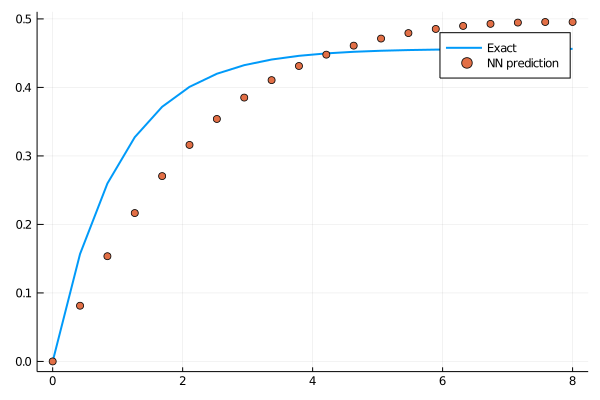

loss: 0.242:  62%|█████████████████████████▎               |  ETA: 0:00:43

0.23759866f0

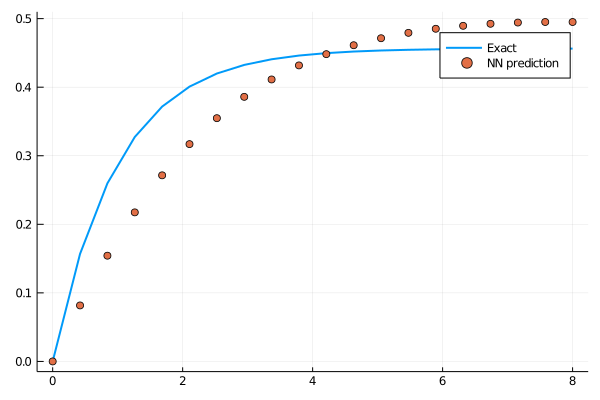

loss: 0.238:  62%|█████████████████████████▍               |  ETA: 0:00:42

0.23370168f0

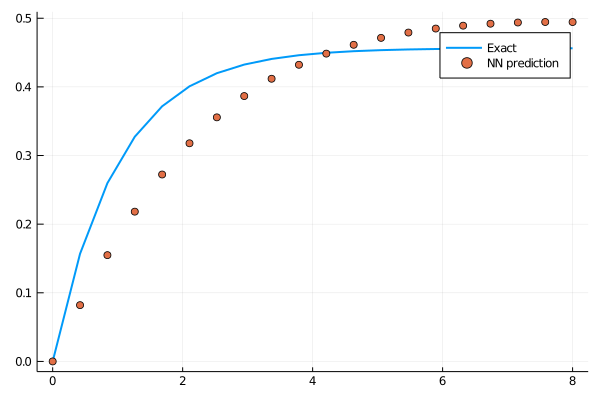

loss: 0.234:  62%|█████████████████████████▋               |  ETA: 0:00:41

0.22990876f0

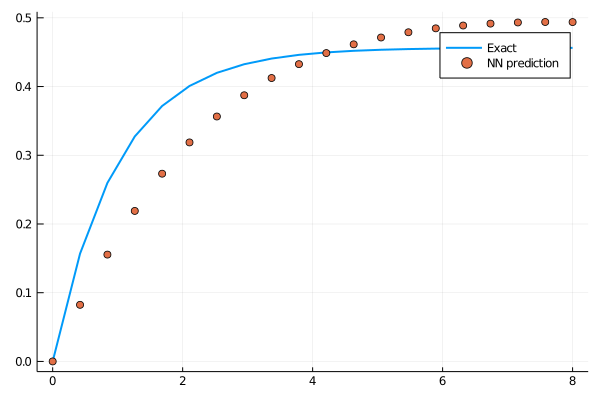

loss: 0.23:  63%|█████████████████████████▉               |  ETA: 0:00:40

0.22621284f0

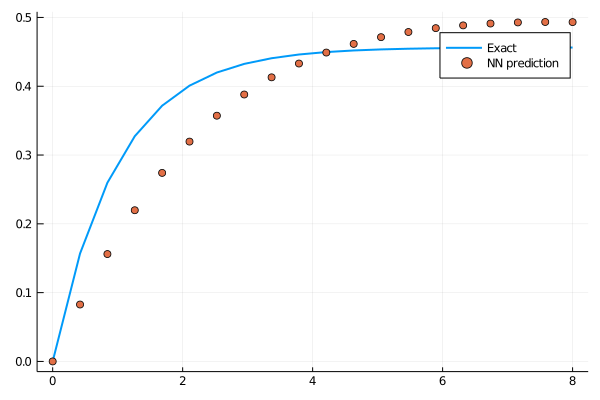

loss: 0.226:  64%|██████████████████████████               |  ETA: 0:00:40

0.22260621f0

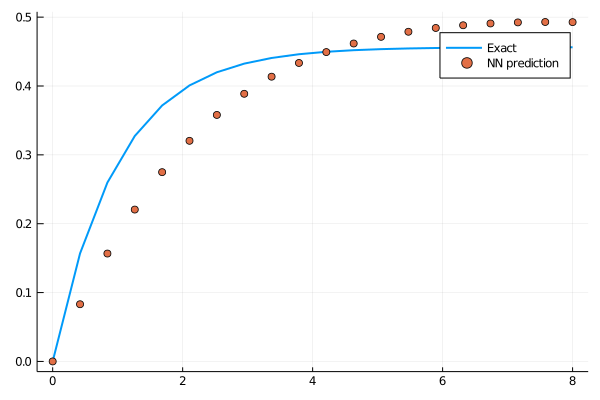

loss: 0.223:  64%|██████████████████████████▎              |  ETA: 0:00:39

0.2190924f0

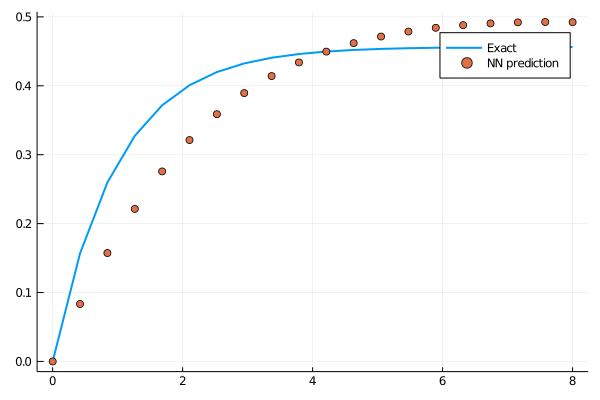

loss: 0.219:  64%|██████████████████████████▌              |  ETA: 0:00:38

0.21566662f0

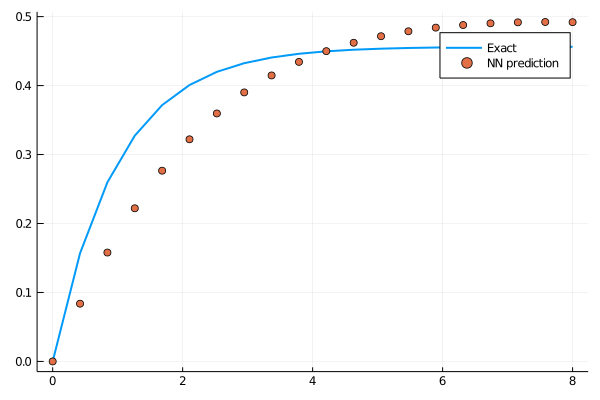

loss: 0.216:  65%|██████████████████████████▋              |  ETA: 0:00:37

0.21231994f0

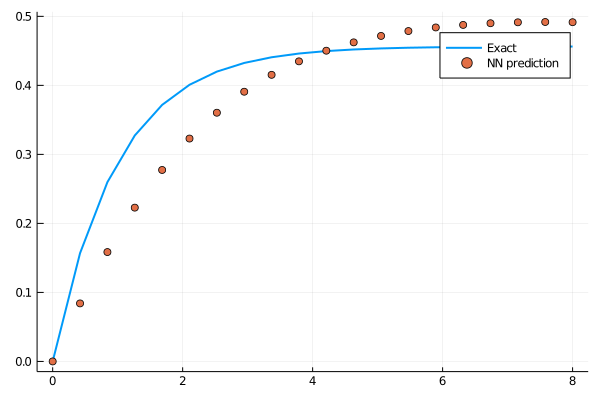

loss: 0.212:  66%|██████████████████████████▉              |  ETA: 0:00:37

0.20905256f0

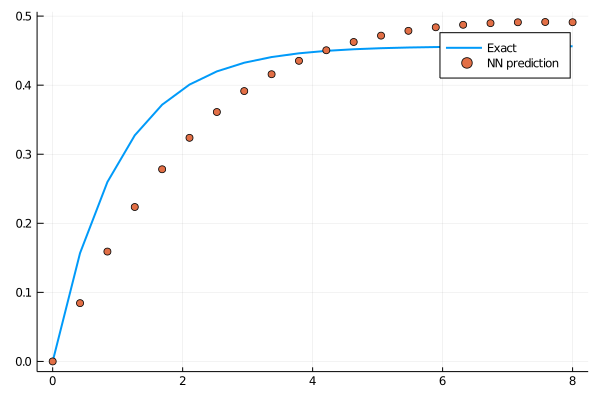

loss: 0.209:  66%|███████████████████████████              |  ETA: 0:00:36

0.20586362f0

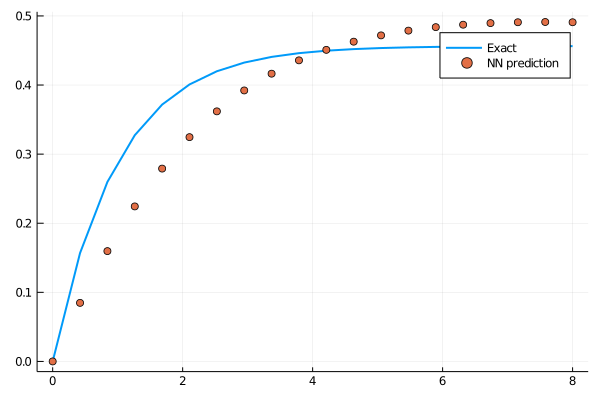

loss: 0.206:  66%|███████████████████████████▎             |  ETA: 0:00:35

0.20275152f0

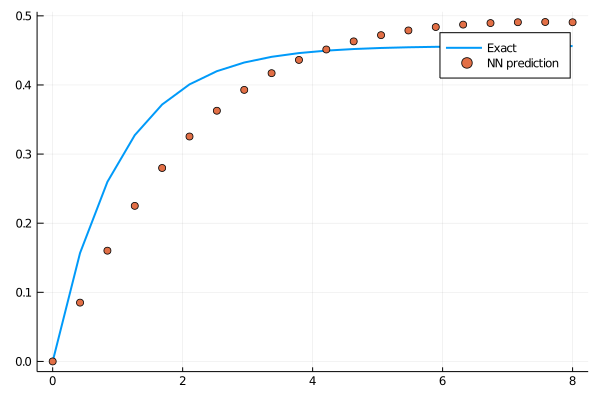

loss: 0.203:  67%|███████████████████████████▌             |  ETA: 0:00:34

0.19971566f0

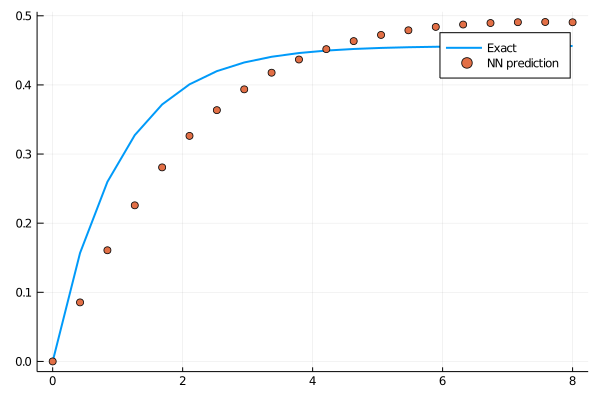

loss: 0.2:  68%|███████████████████████████▋             |  ETA: 0:00:34

0.19675013f0

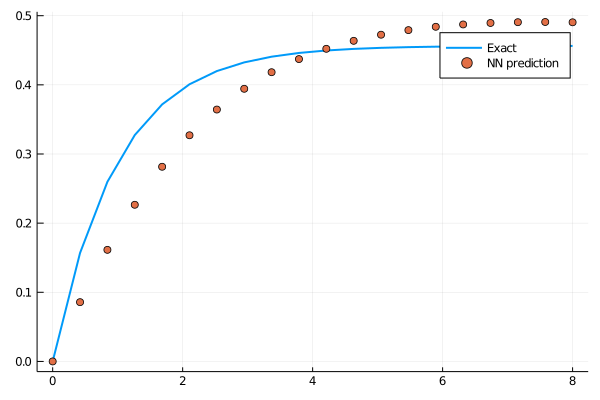

loss: 0.197:  68%|███████████████████████████▉             |  ETA: 0:00:33

0.19385056f0

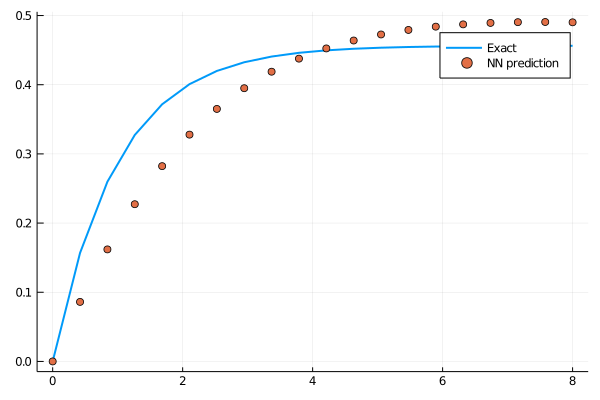

loss: 0.194:  68%|████████████████████████████▏            |  ETA: 0:00:32

0.19101717f0

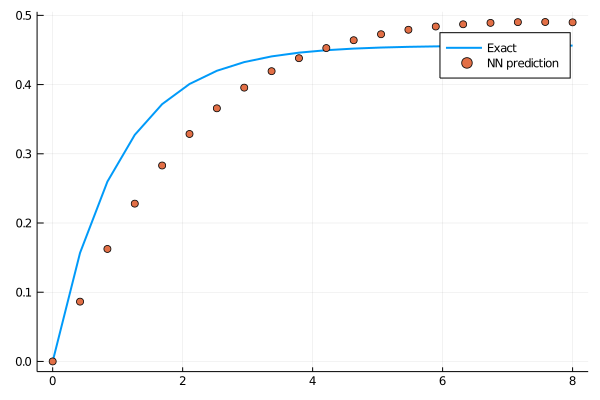

loss: 0.191:  69%|████████████████████████████▎            |  ETA: 0:00:32

0.18824695f0

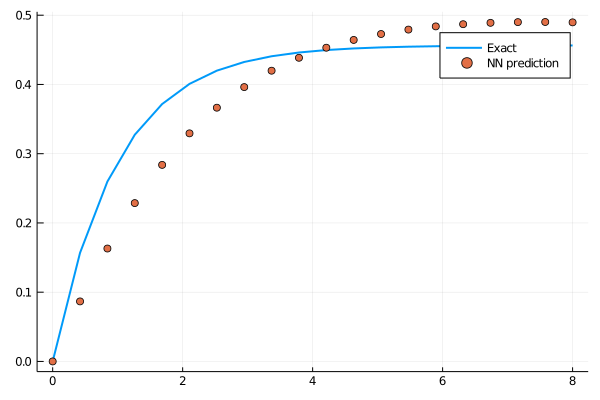

loss: 0.188:  70%|████████████████████████████▌            |  ETA: 0:00:31

0.18553694f0

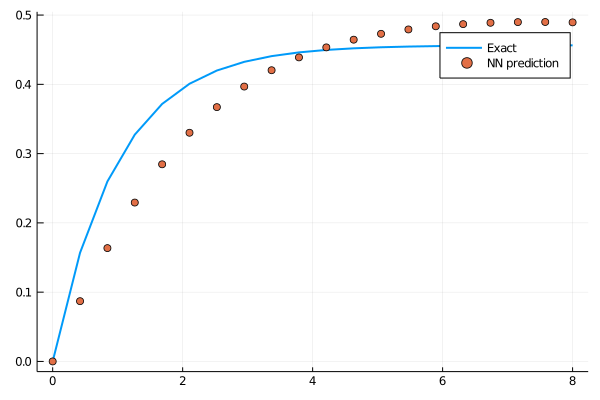

loss: 0.186:  70%|████████████████████████████▊            |  ETA: 0:00:30

0.18288748f0

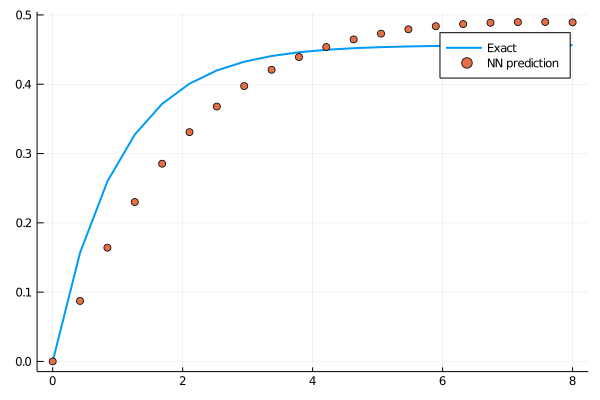

loss: 0.183:  70%|████████████████████████████▉            |  ETA: 0:00:30

0.18029556f0

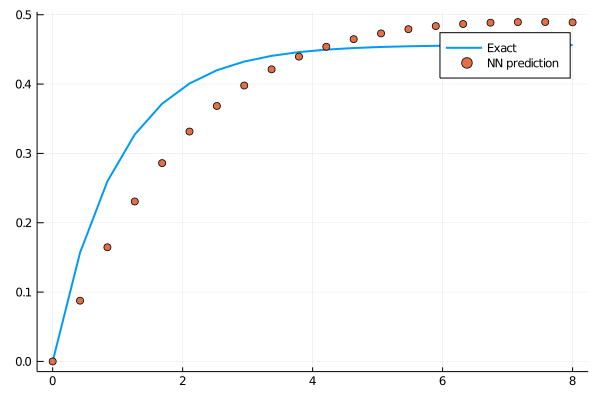

loss: 0.18:  71%|█████████████████████████████▏           |  ETA: 0:00:29

0.17775851f0

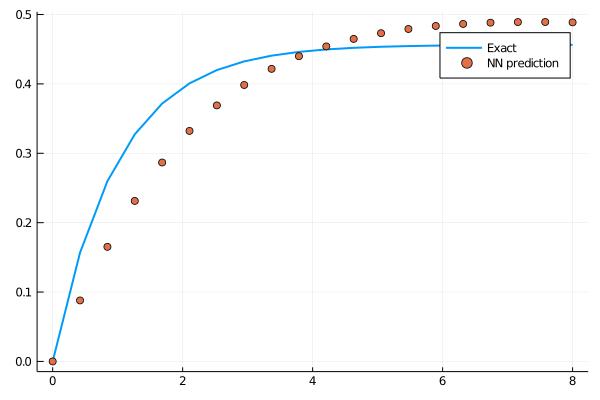

loss: 0.178:  72%|█████████████████████████████▍           |  ETA: 0:00:29

0.17527549f0

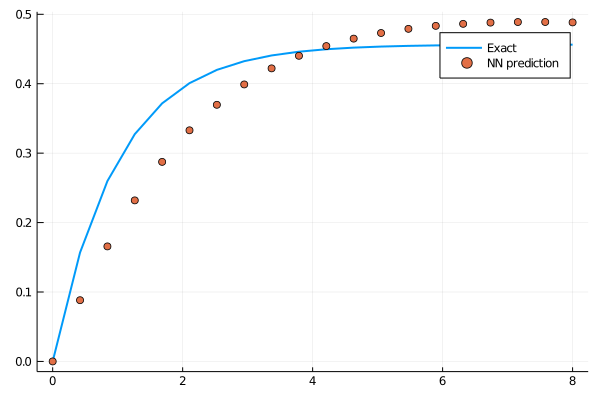

loss: 0.175:  72%|█████████████████████████████▌           |  ETA: 0:00:28

0.17284425f0

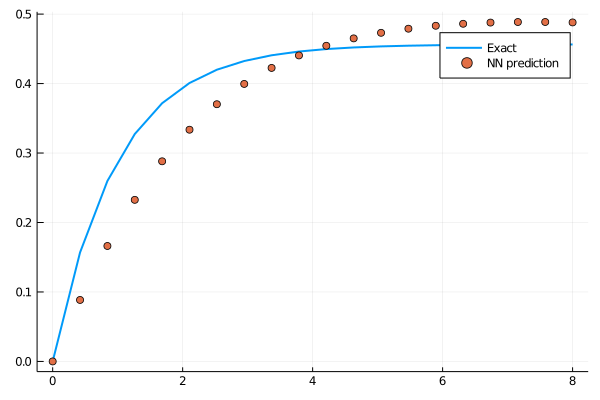

loss: 0.173:  72%|█████████████████████████████▊           |  ETA: 0:00:27

0.17046323f0

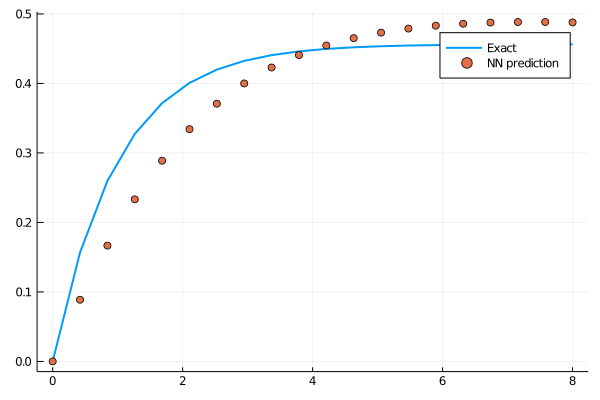

loss: 0.17:  73%|█████████████████████████████▉           |  ETA: 0:00:27

0.16813123f0

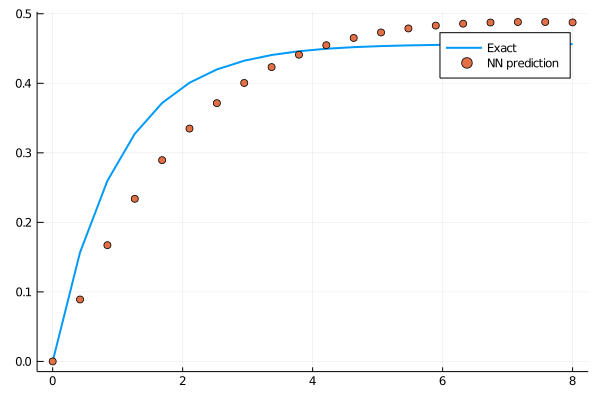

loss: 0.168:  74%|██████████████████████████████▏          |  ETA: 0:00:26

0.16584587f0

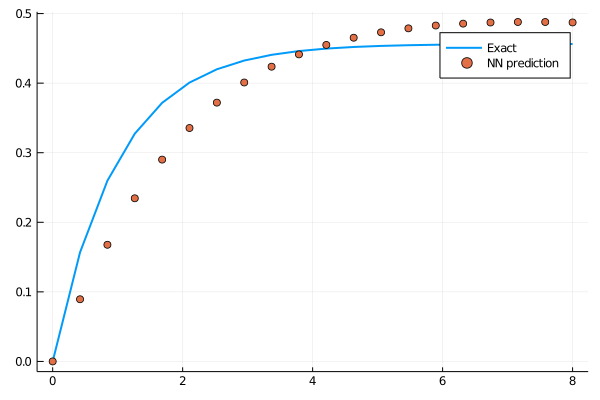

loss: 0.166:  74%|██████████████████████████████▍          |  ETA: 0:00:25

0.16360602f0

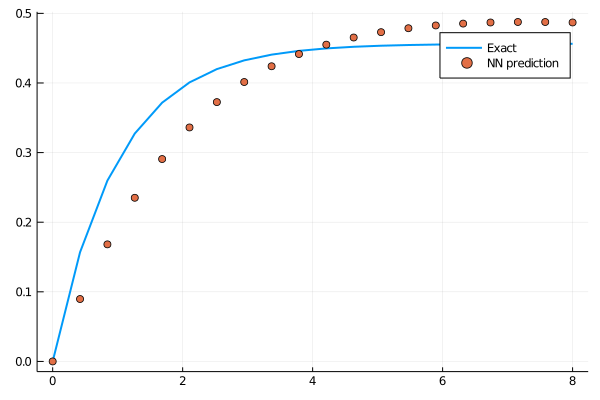

loss: 0.164:  74%|██████████████████████████████▌          |  ETA: 0:00:25

0.16141096f0

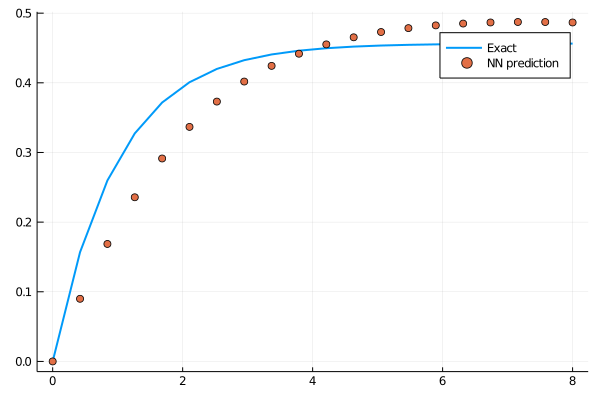

loss: 0.161:  75%|██████████████████████████████▊          |  ETA: 0:00:24

0.159259f0

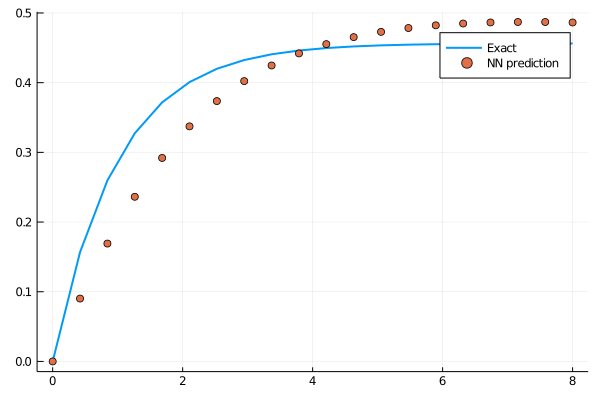

loss: 0.159:  76%|███████████████████████████████          |  ETA: 0:00:24

0.15714927f0

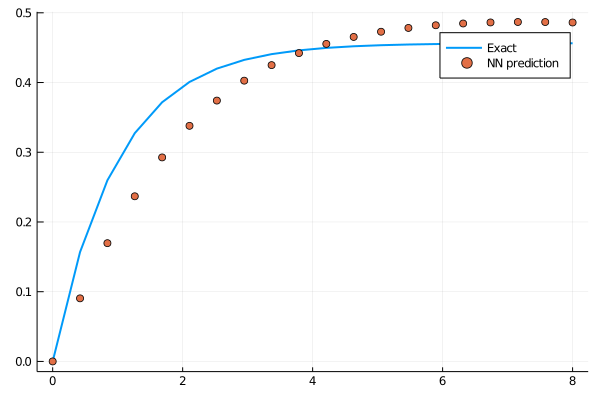

loss: 0.157:  76%|███████████████████████████████▏         |  ETA: 0:00:23

0.15508026f0

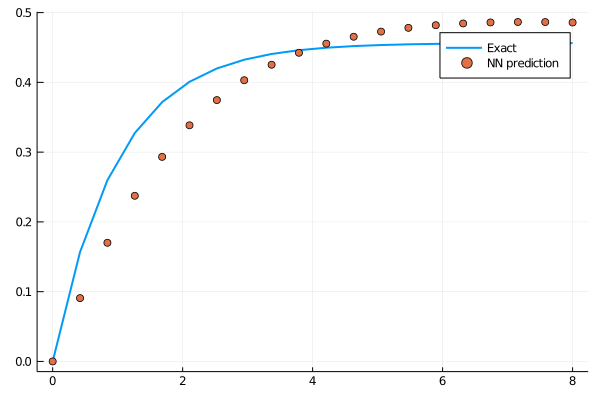

loss: 0.155:  76%|███████████████████████████████▍         |  ETA: 0:00:22

0.15305026f0

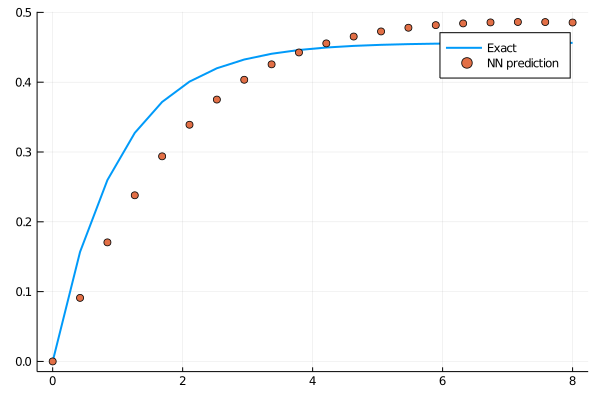

loss: 0.153:  77%|███████████████████████████████▋         |  ETA: 0:00:22

0.15105855f0

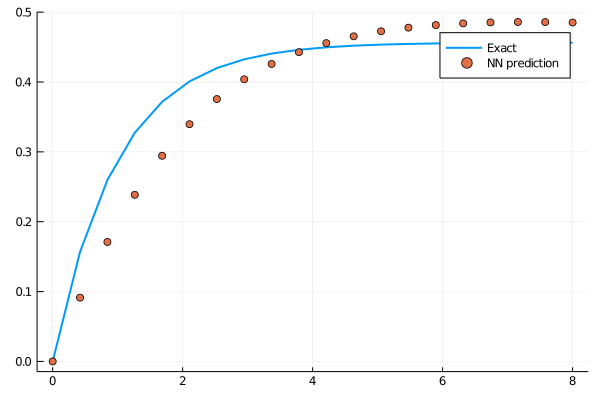

loss: 0.151:  78%|███████████████████████████████▊         |  ETA: 0:00:21

0.14910425f0

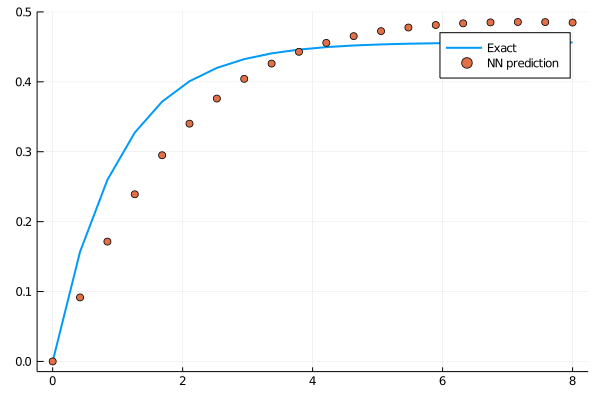

loss: 0.149:  78%|████████████████████████████████         |  ETA: 0:00:21

0.14718646f0

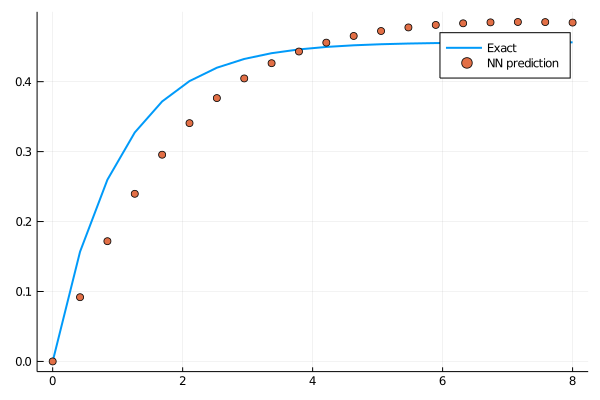

loss: 0.147:  78%|████████████████████████████████▏        |  ETA: 0:00:20

0.1453045f0

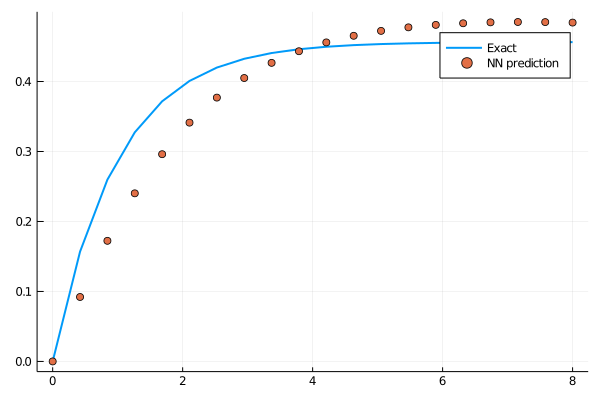

loss: 0.145:  79%|████████████████████████████████▍        |  ETA: 0:00:20

0.14345716f0

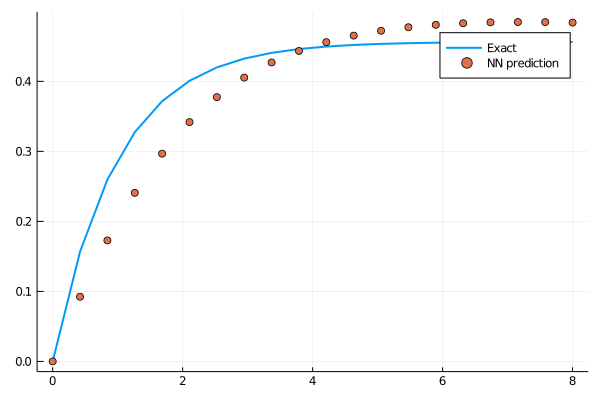

loss: 0.143:  80%|████████████████████████████████▋        |  ETA: 0:00:19

0.14164335f0

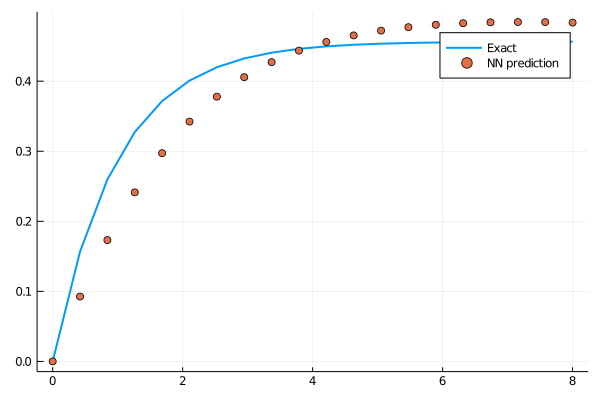

loss: 0.142:  80%|████████████████████████████████▊        |  ETA: 0:00:19

0.13986222f0

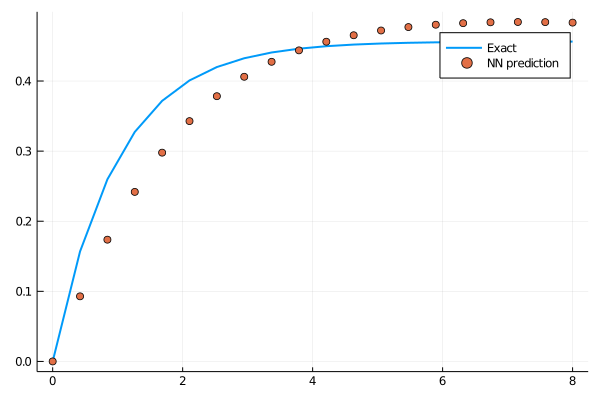

loss: 0.14:  80%|█████████████████████████████████        |  ETA: 0:00:18

0.13811274f0

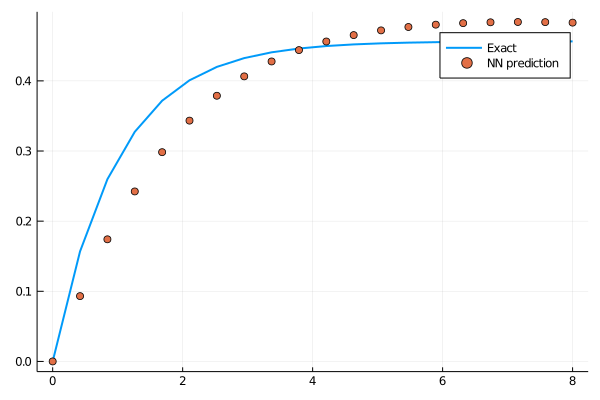

loss: 0.138:  81%|█████████████████████████████████▎       |  ETA: 0:00:18

0.13639426f0

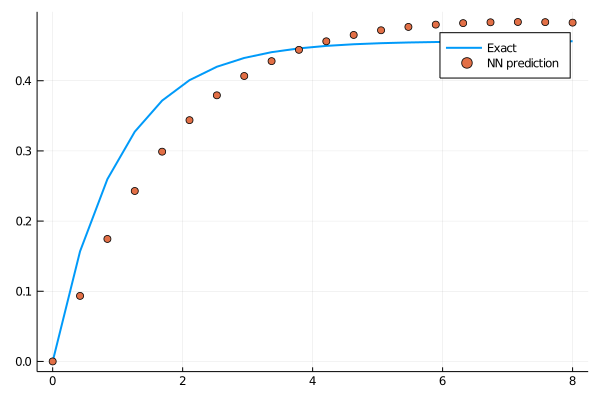

loss: 0.136:  82%|█████████████████████████████████▍       |  ETA: 0:00:17

0.13470618f0

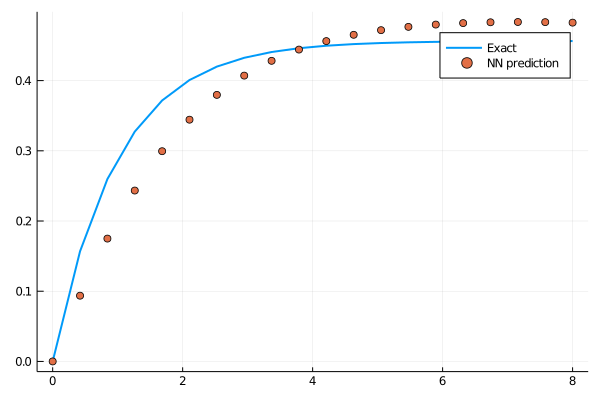

loss: 0.135:  82%|█████████████████████████████████▋       |  ETA: 0:00:16

0.13304742f0

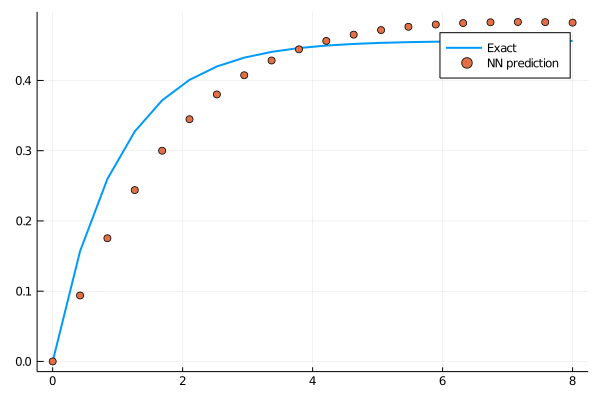

loss: 0.133:  82%|█████████████████████████████████▉       |  ETA: 0:00:16

0.13141721f0

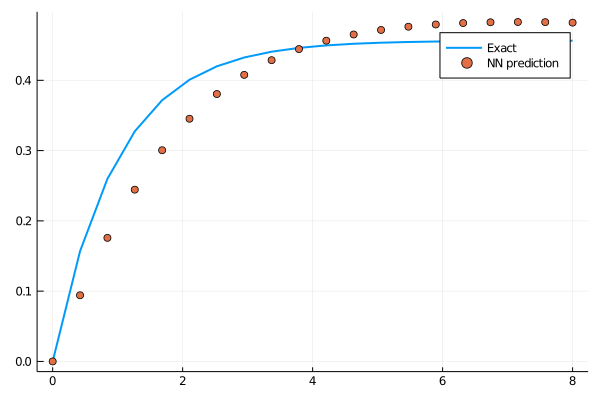

loss: 0.131:  83%|██████████████████████████████████       |  ETA: 0:00:15

0.1298149f0

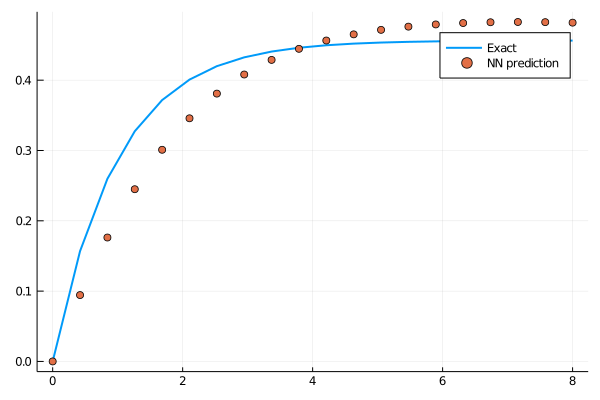

loss: 0.13:  84%|██████████████████████████████████▎      |  ETA: 0:00:15

0.12823965f0

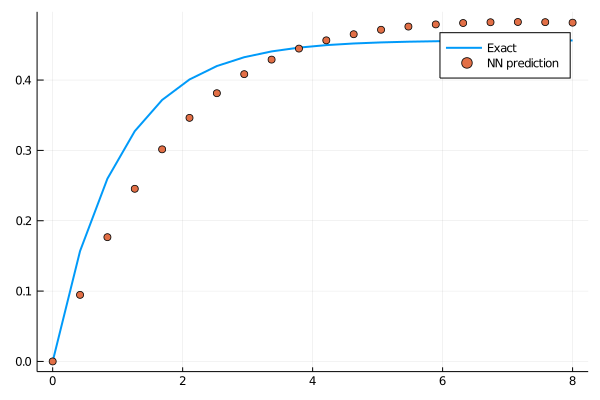

loss: 0.128:  84%|██████████████████████████████████▌      |  ETA: 0:00:14

0.12669113f0

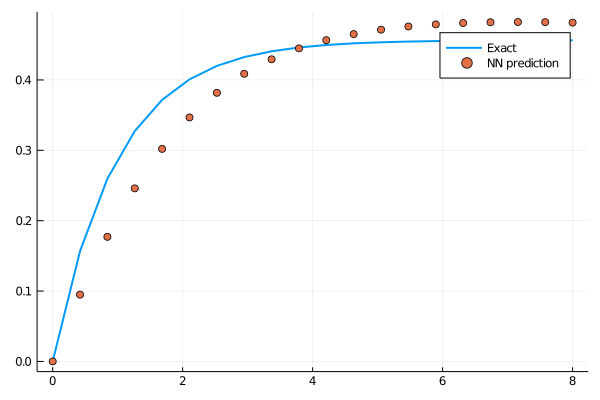

loss: 0.127:  84%|██████████████████████████████████▋      |  ETA: 0:00:14

0.12516841f0

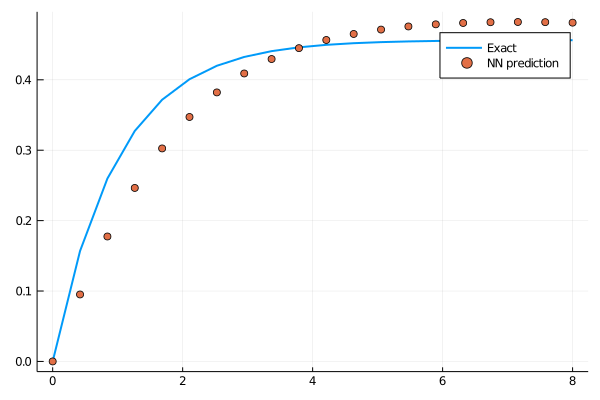

loss: 0.125:  85%|██████████████████████████████████▉      |  ETA: 0:00:13

0.12367104f0

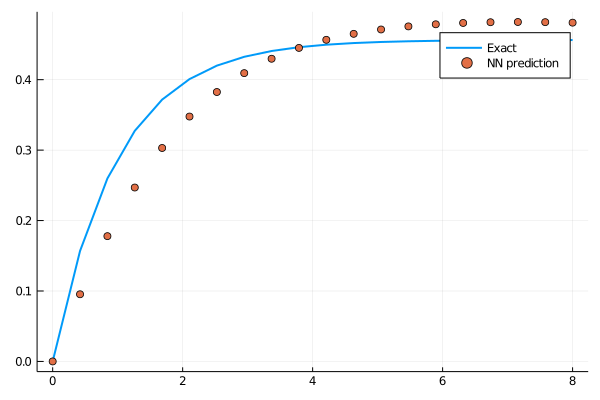

loss: 0.124:  86%|███████████████████████████████████      |  ETA: 0:00:13

0.12219828f0

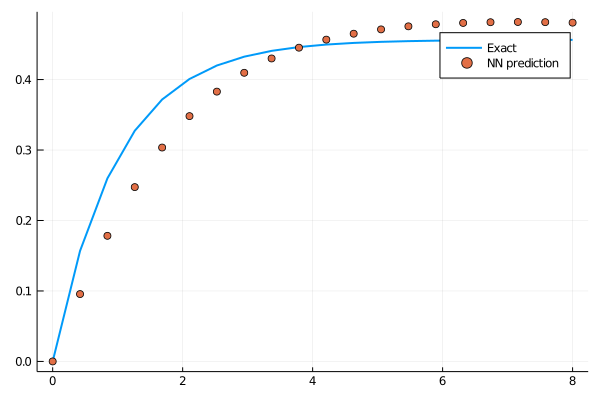

loss: 0.122:  86%|███████████████████████████████████▎     |  ETA: 0:00:12

0.120749645f0

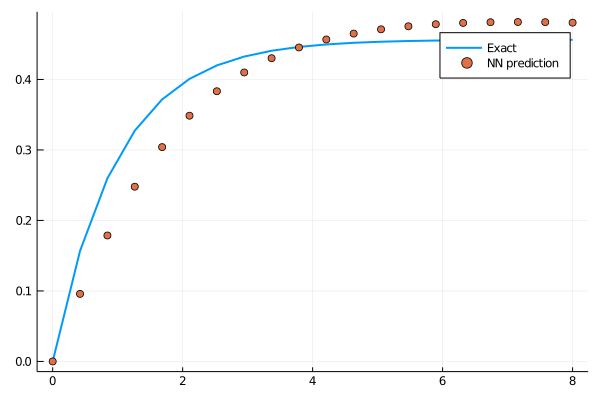

loss: 0.121:  86%|███████████████████████████████████▌     |  ETA: 0:00:12

0.119324446f0

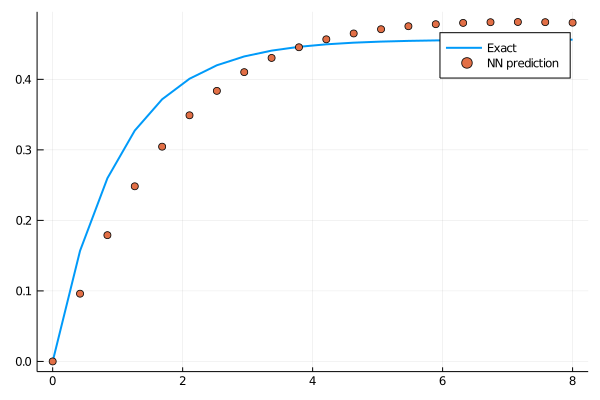

loss: 0.119:  87%|███████████████████████████████████▋     |  ETA: 0:00:11

0.11792217f0

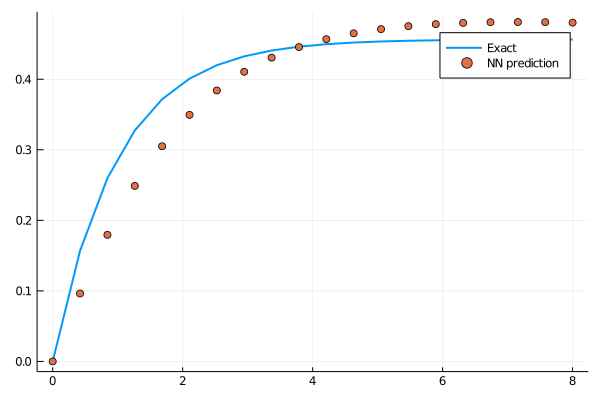

loss: 0.118:  88%|███████████████████████████████████▉     |  ETA: 0:00:11

0.11654224f0

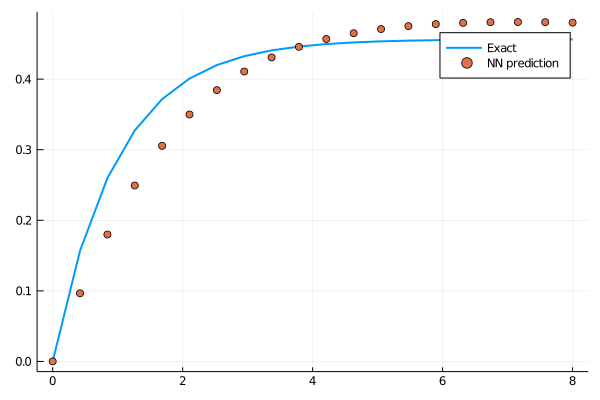

loss: 0.117:  88%|████████████████████████████████████▏    |  ETA: 0:00:11

0.11518421f0

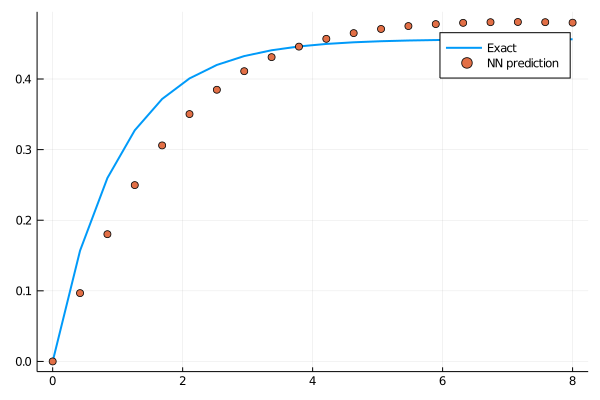

loss: 0.115:  88%|████████████████████████████████████▎    |  ETA: 0:00:10

0.113847606f0

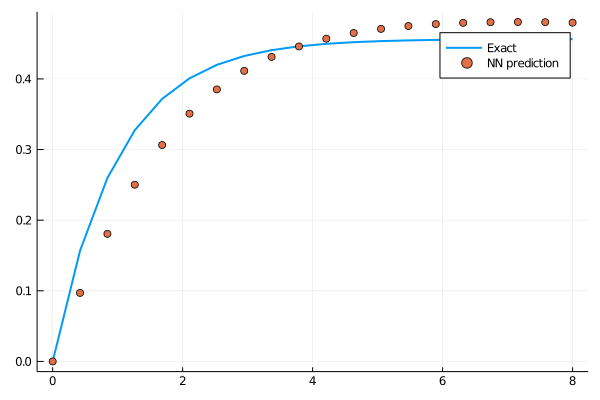

loss: 0.114:  89%|████████████████████████████████████▌    |  ETA: 0:00:10

0.1125317f0

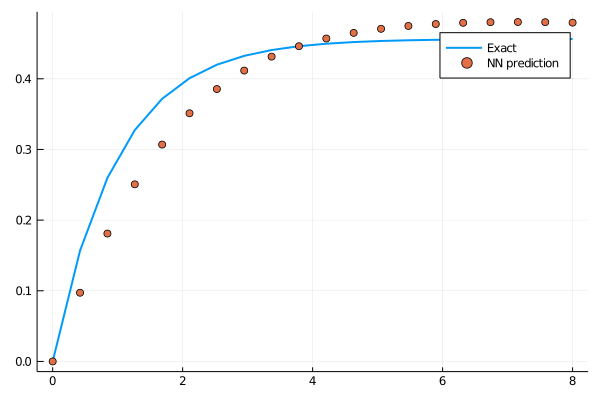

loss: 0.113:  90%|████████████████████████████████████▊    |  ETA: 0:00:09

0.11123636f0

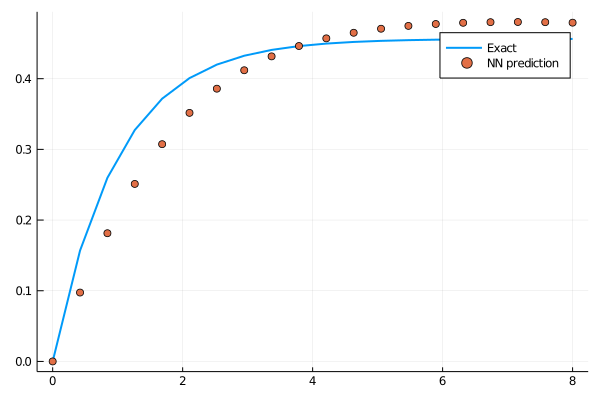

loss: 0.111:  90%|████████████████████████████████████▉    |  ETA: 0:00:09

0.10996101f0

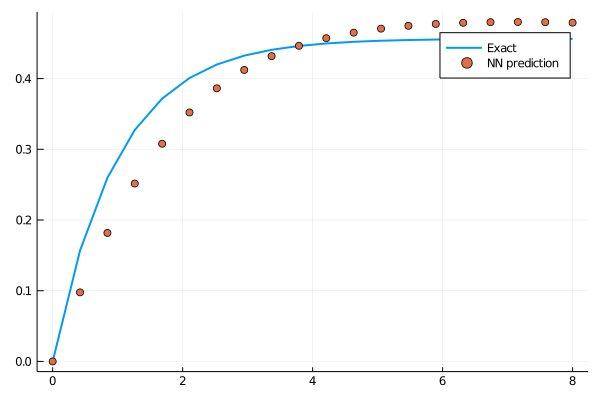

loss: 0.11:  90%|█████████████████████████████████████▏   |  ETA: 0:00:08

0.10870521f0

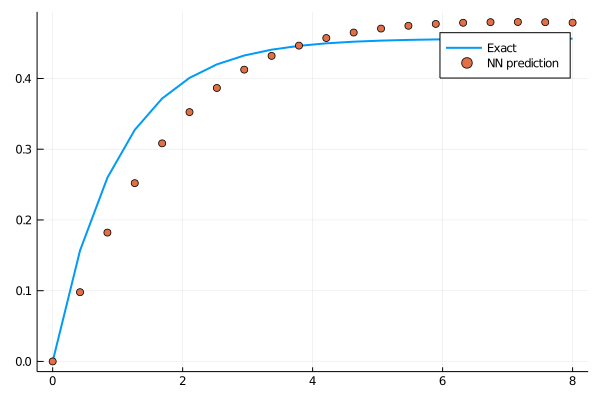

loss: 0.109:  91%|█████████████████████████████████████▎   |  ETA: 0:00:08

0.10746851f0

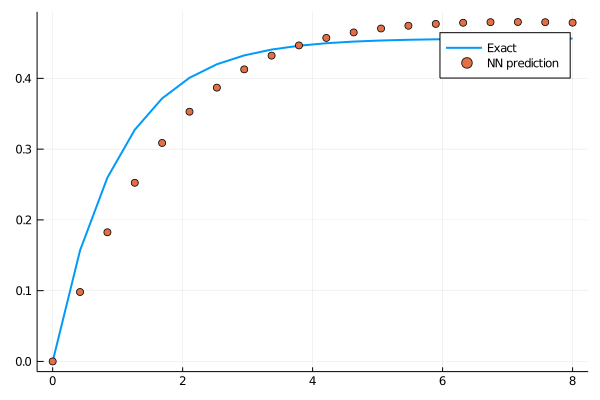

loss: 0.107:  92%|█████████████████████████████████████▌   |  ETA: 0:00:07

0.10625053f0

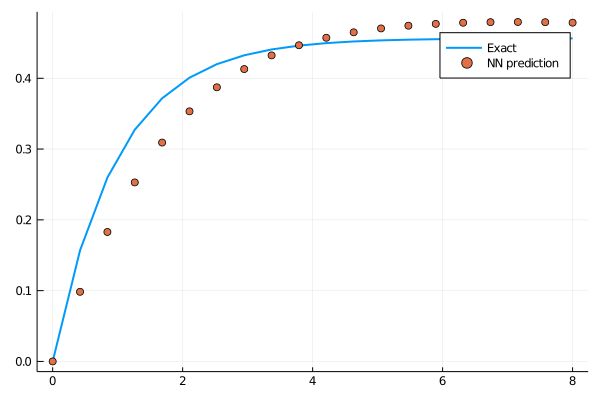

loss: 0.106:  92%|█████████████████████████████████████▊   |  ETA: 0:00:07

0.10505078f0

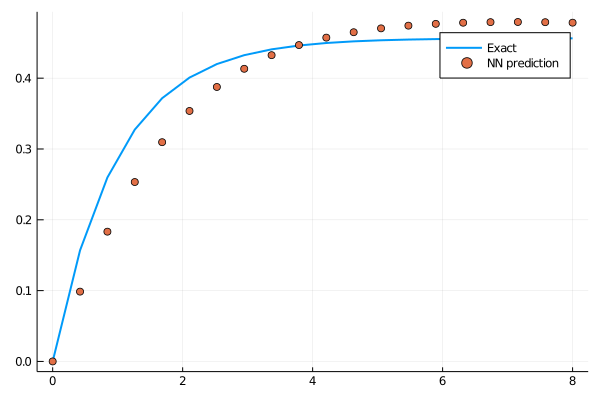

loss: 0.105:  92%|█████████████████████████████████████▉   |  ETA: 0:00:06

0.103868924f0

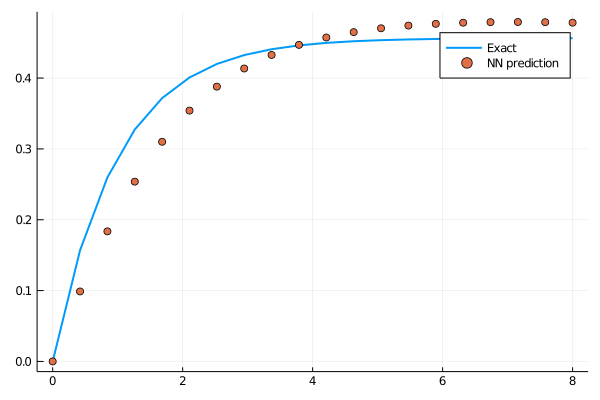

loss: 0.104:  93%|██████████████████████████████████████▏  |  ETA: 0:00:06

0.102704674f0

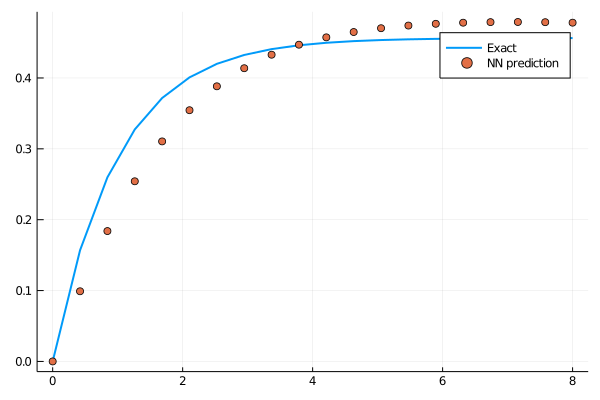

loss: 0.103:  94%|██████████████████████████████████████▍  |  ETA: 0:00:06

0.101557456f0

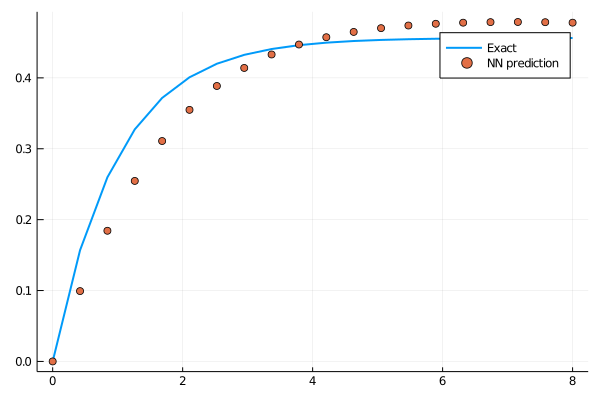

loss: 0.102:  94%|██████████████████████████████████████▌  |  ETA: 0:00:05

0.100427136f0

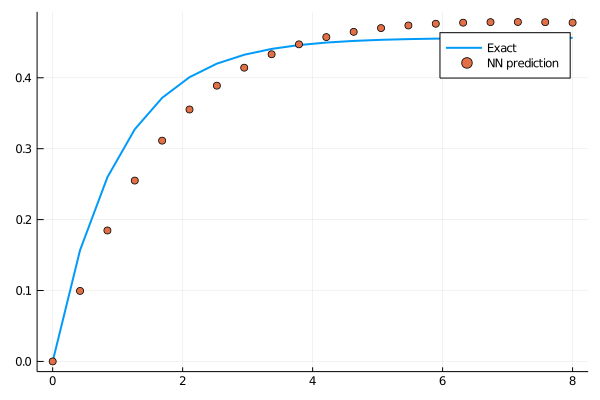

loss: 0.1:  94%|██████████████████████████████████████▊  |  ETA: 0:00:05

0.099313244f0

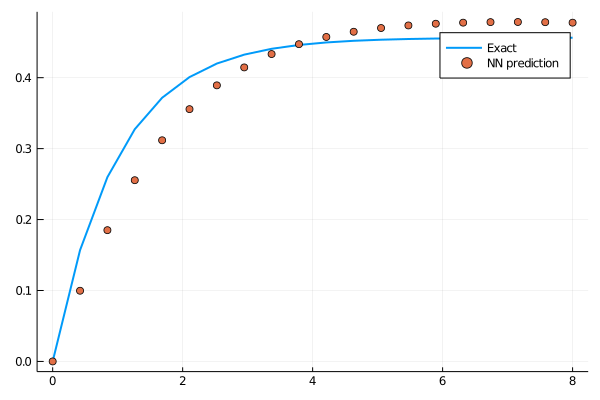

loss: 0.0993:  95%|███████████████████████████████████████  |  ETA: 0:00:04

0.09821544f0

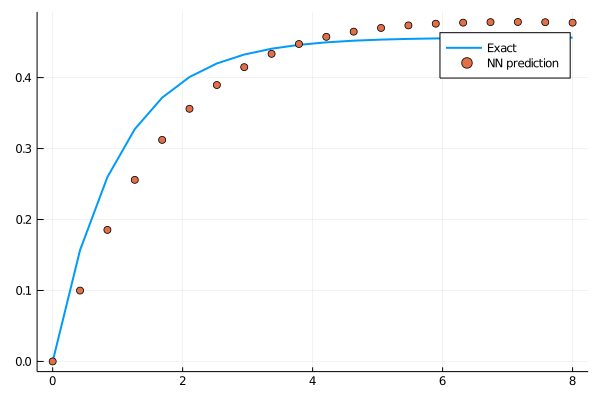

loss: 0.0982:  96%|███████████████████████████████████████▏ |  ETA: 0:00:04

0.09713347f0

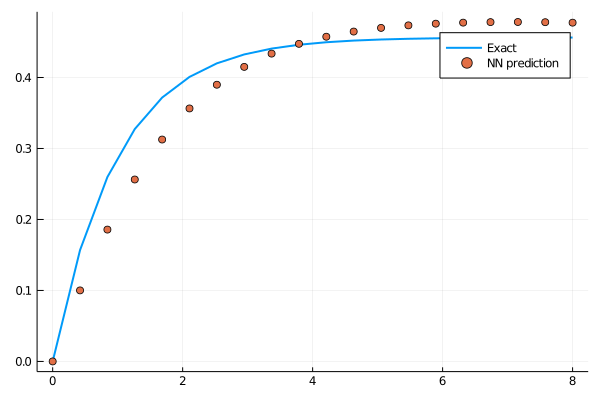

loss: 0.0971:  96%|███████████████████████████████████████▍ |  ETA: 0:00:03

0.096067004f0

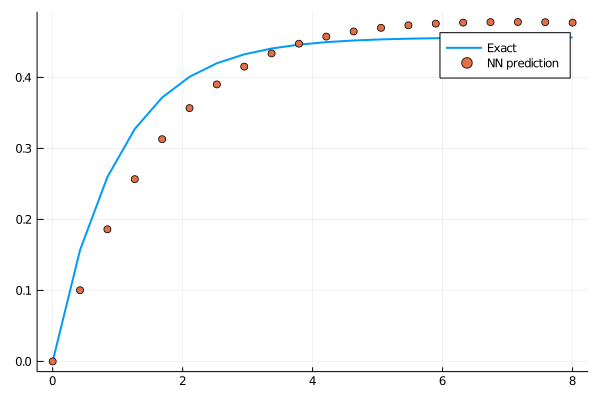

loss: 0.0961:  96%|███████████████████████████████████████▋ |  ETA: 0:00:03

0.095015615f0

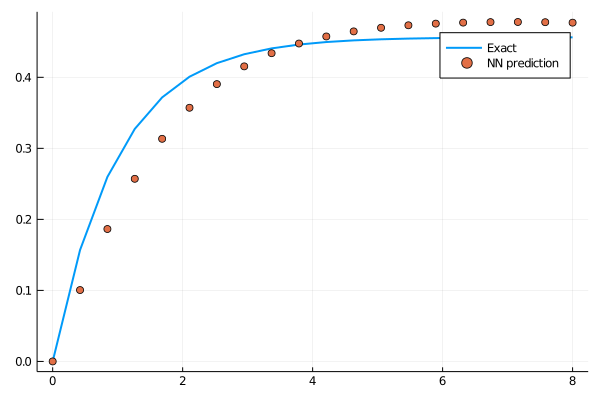

loss: 0.095:  97%|███████████████████████████████████████▊ |  ETA: 0:00:02

0.093979195f0

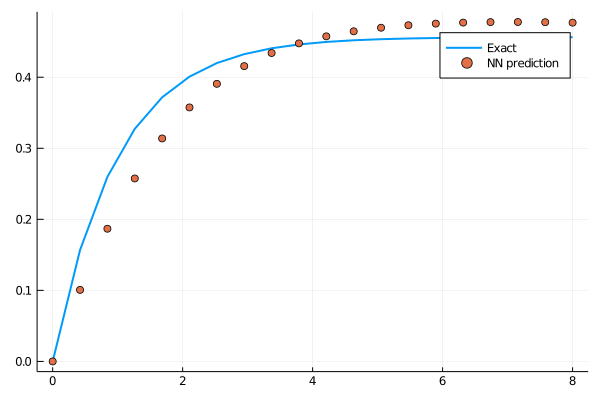

loss: 0.094:  98%|████████████████████████████████████████ |  ETA: 0:00:02

0.09295729f0

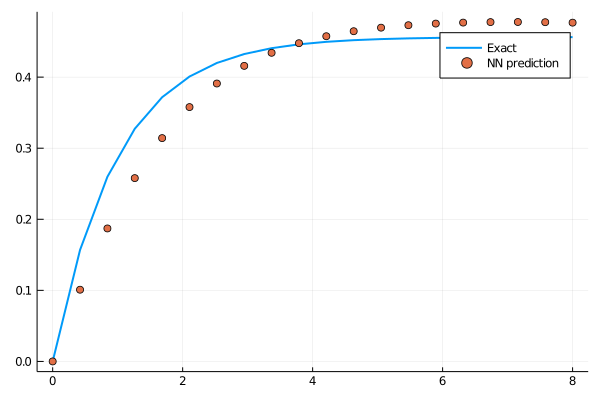

loss: 0.093:  98%|████████████████████████████████████████▏|  ETA: 0:00:02

0.09194963f0

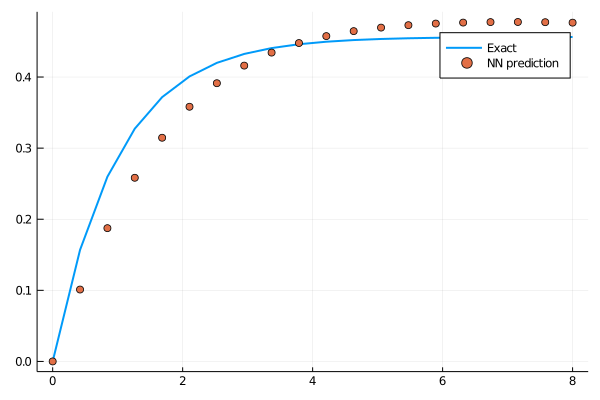

loss: 0.0919:  98%|████████████████████████████████████████▍|  ETA: 0:00:01

0.09095595f0

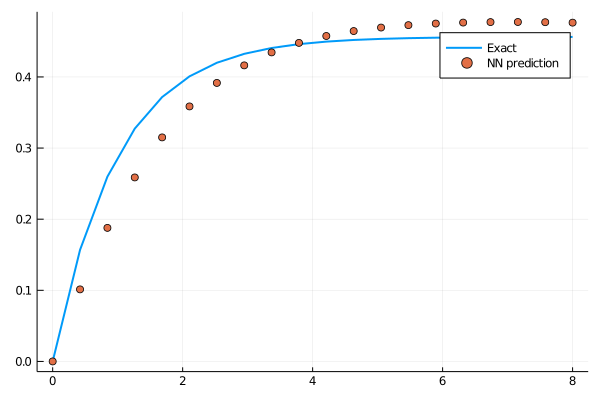

loss: 0.091:  99%|████████████████████████████████████████▋|  ETA: 0:00:01

0.089976124f0

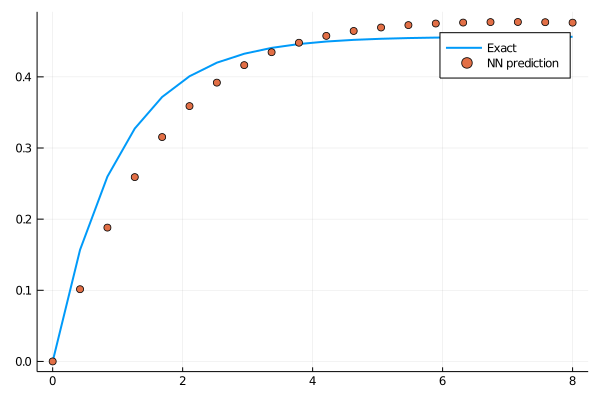

loss: 0.09: 100%|████████████████████████████████████████▊|  ETA: 0:00:00

0.089009725f0

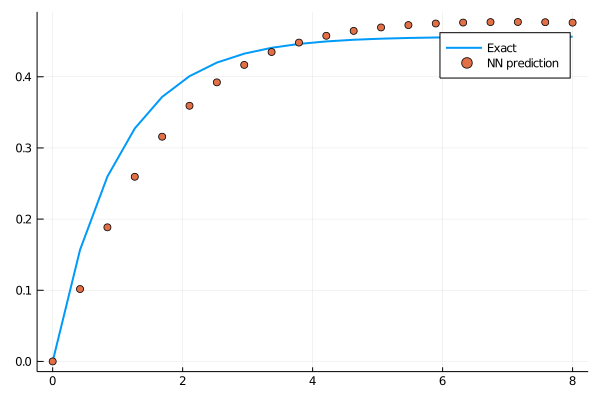

loss: 0.089: 100%|█████████████████████████████████████████| Time: 0:01:21


0.089009725f0

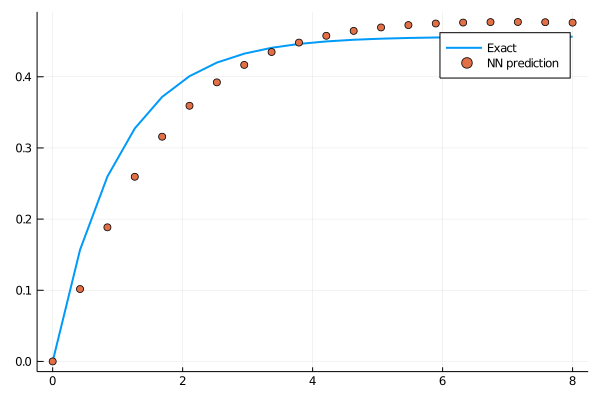

0.08805641f0

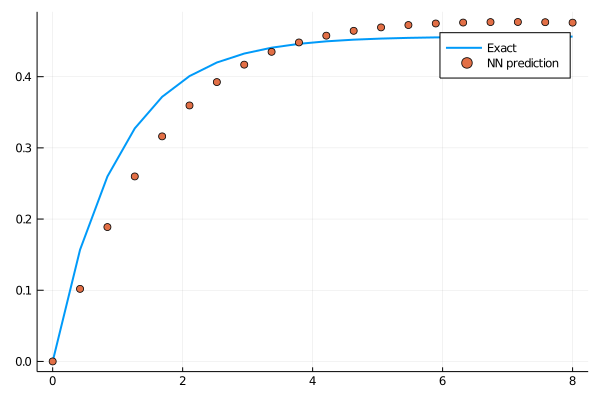

0.085913196f0

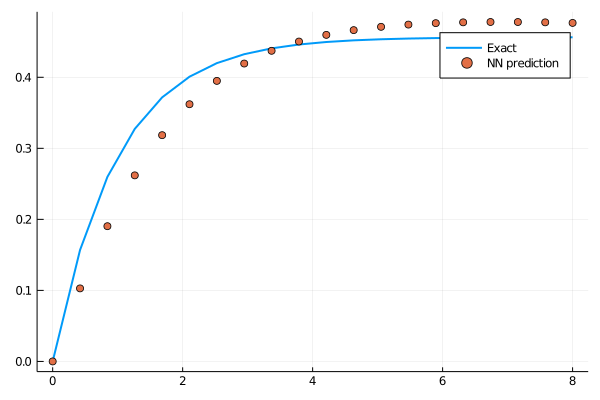

0.08460359f0

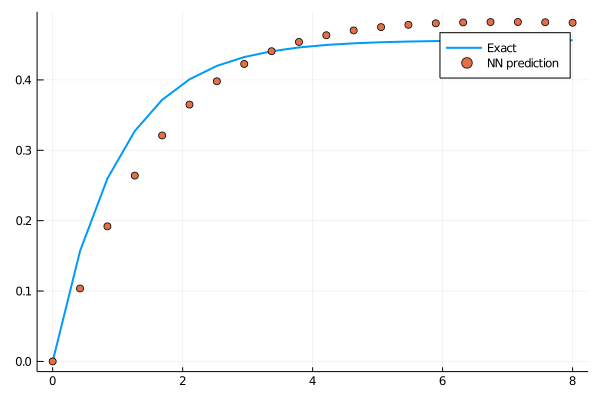

0.08273369f0

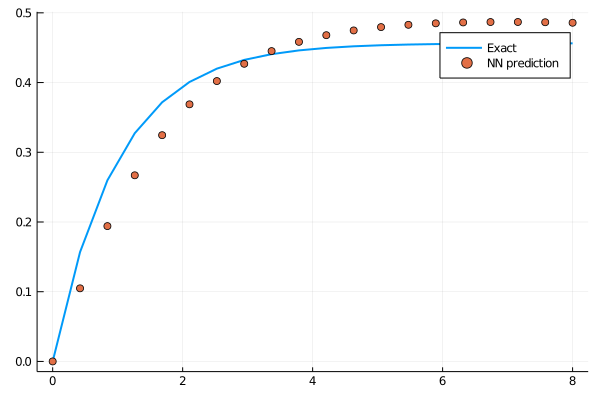

0.08108167f0

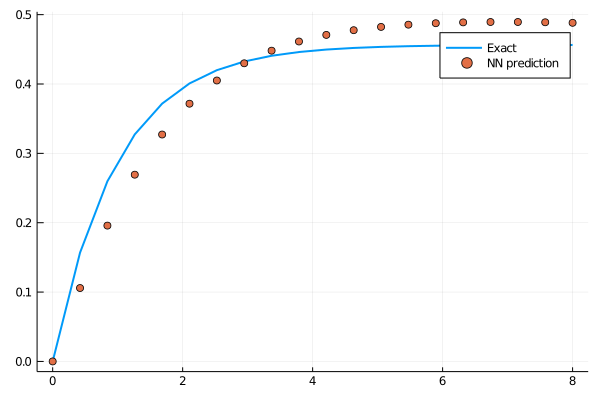

0.08030067f0

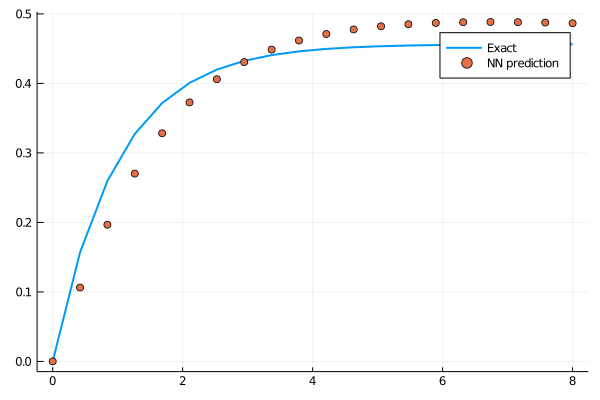

0.07977562f0

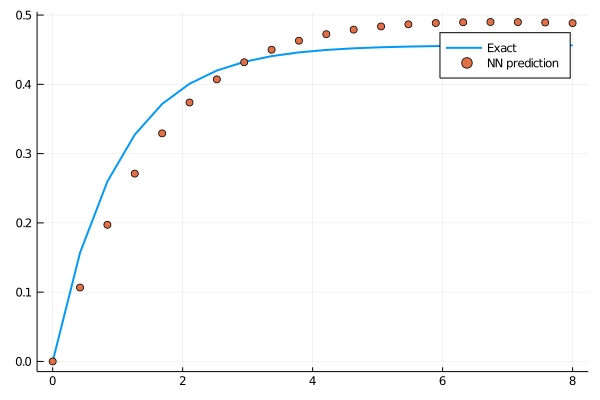

0.079052344f0

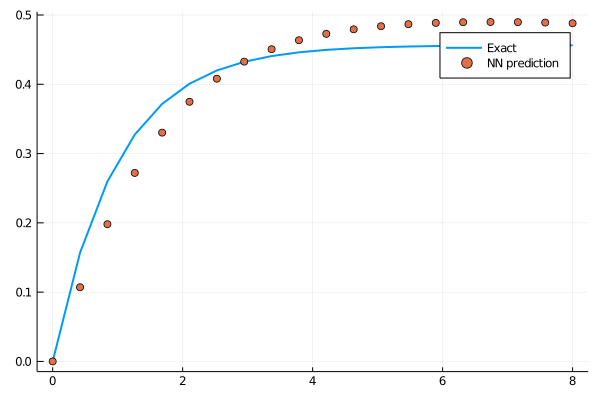

0.078222215f0

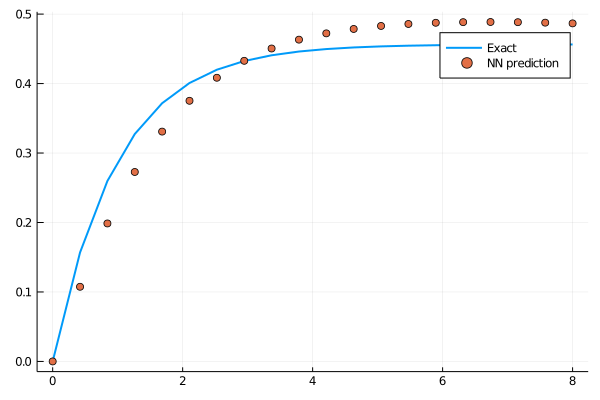

0.076577306f0

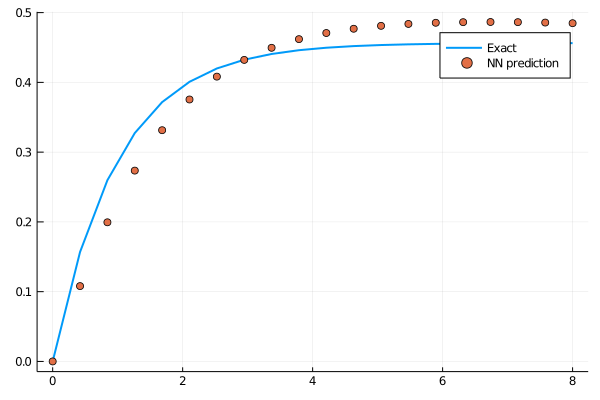

0.07208585f0

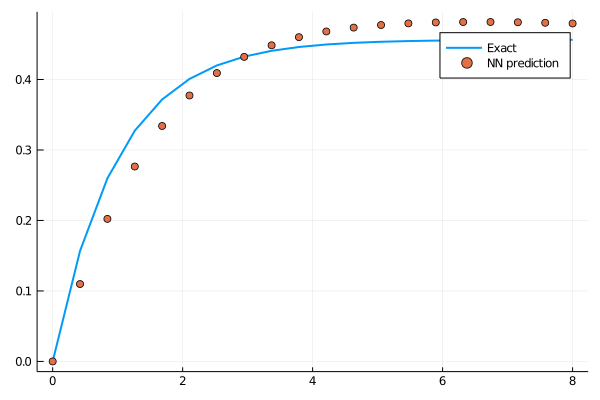

0.067245826f0

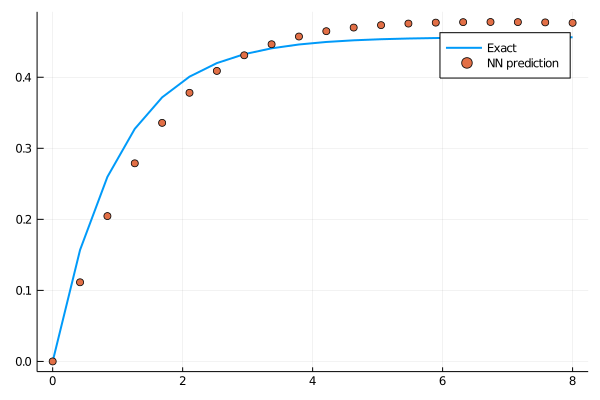

0.058169022f0

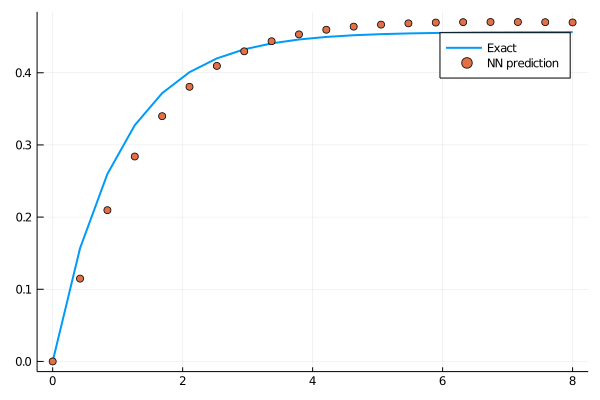

0.045228373f0

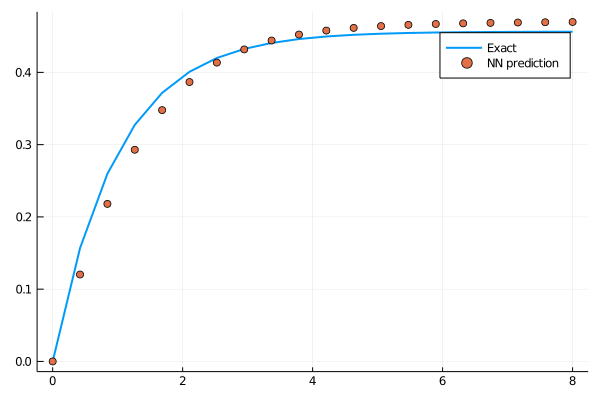

0.034723036f0

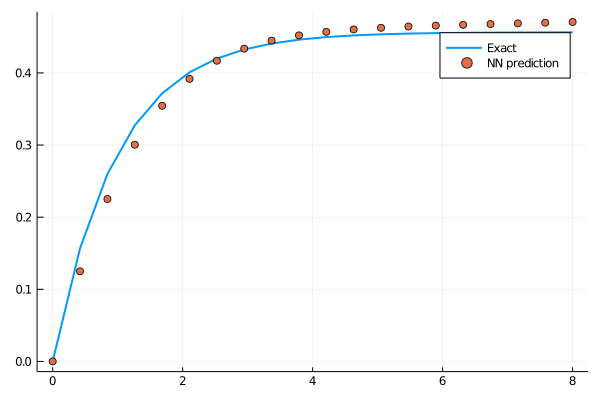

0.029795552f0

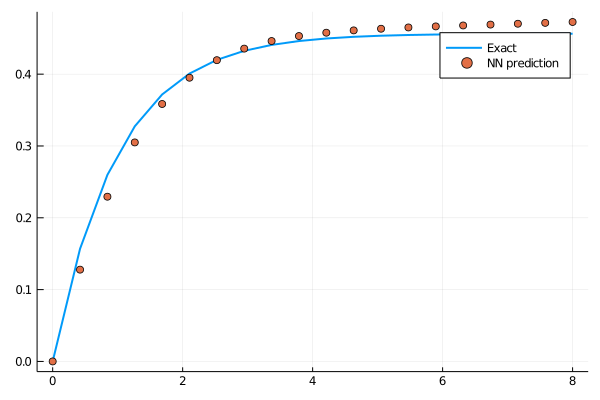

0.02332277f0

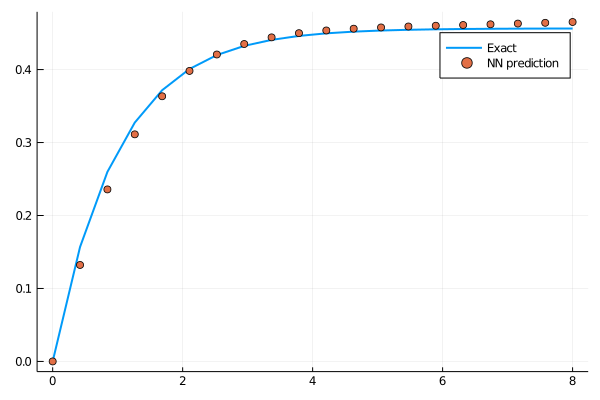

0.01889266f0

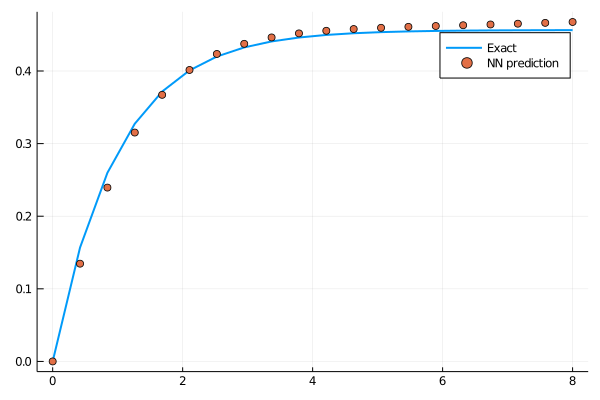

0.017304651f0

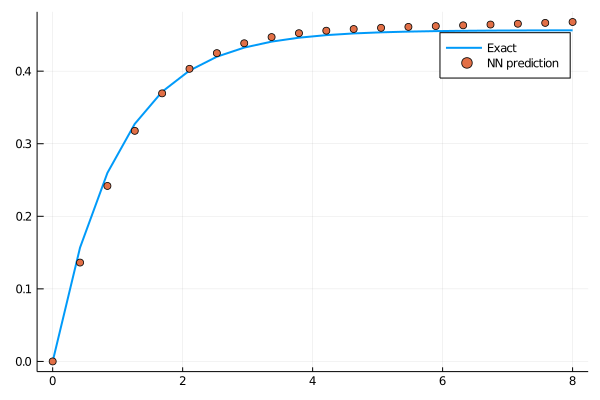

0.016734777f0

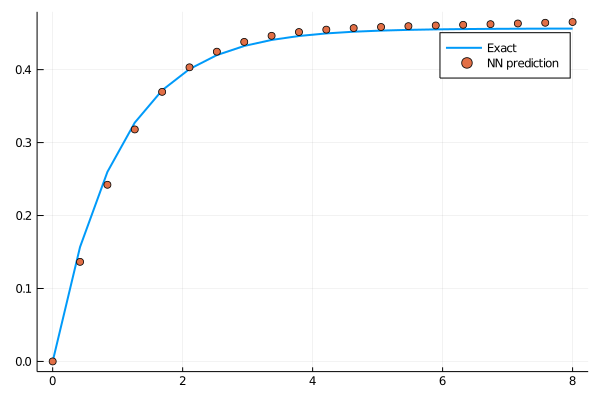

0.016271621f0

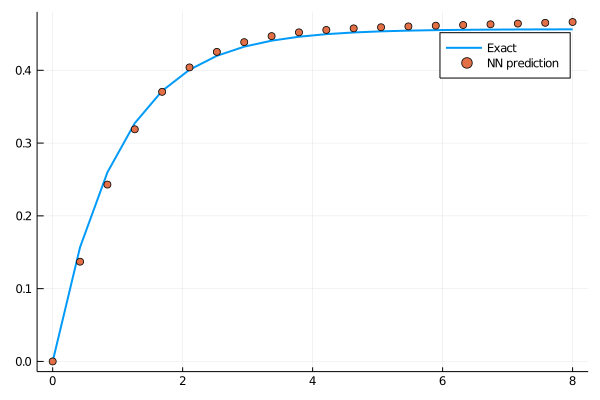

0.016067538f0

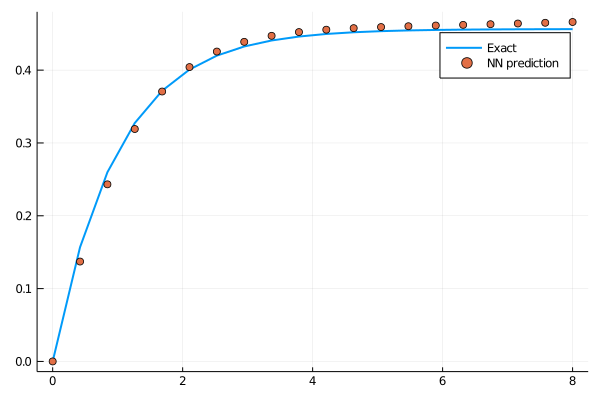

0.015849773f0

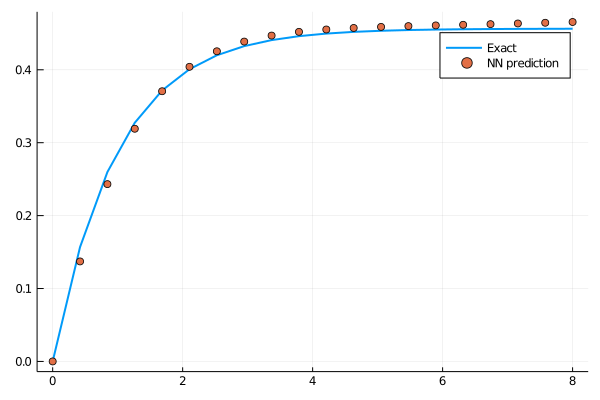

0.015622429f0

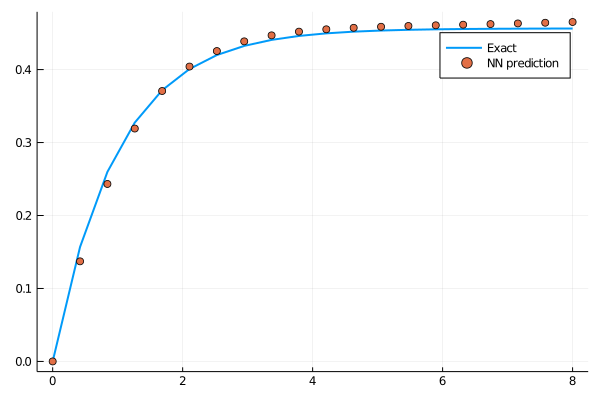

0.015394525f0

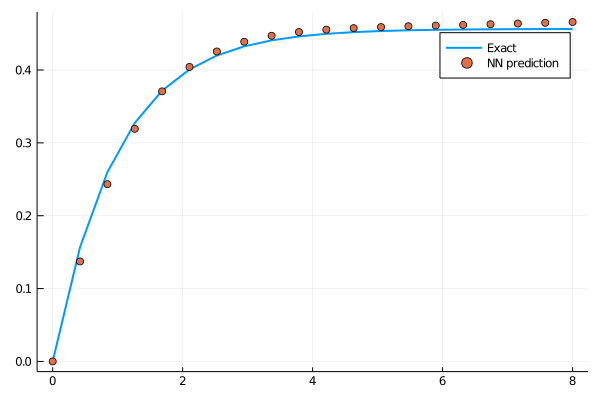

0.014850043f0

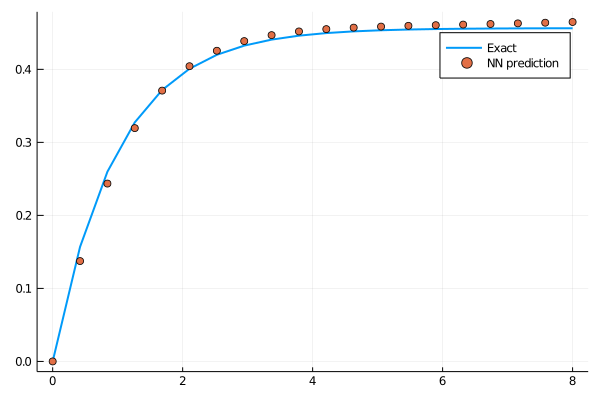

0.014257595f0

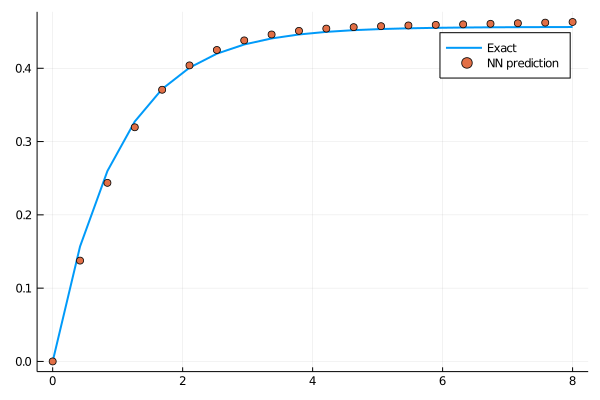

0.013935315f0

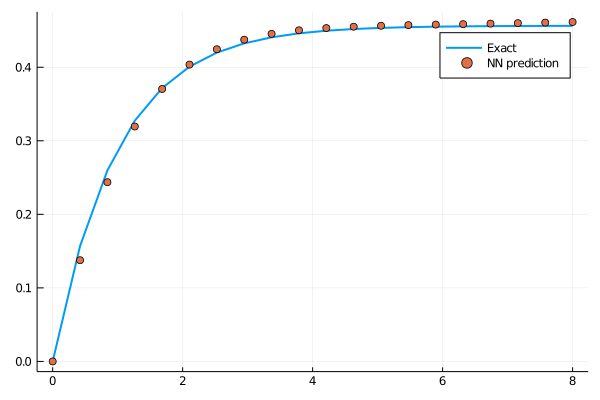

0.012648607f0

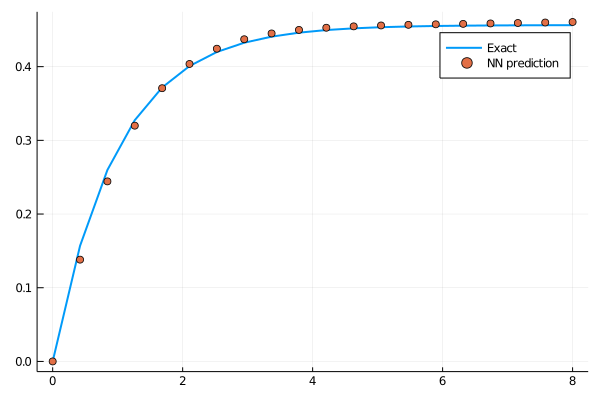

0.010270688f0

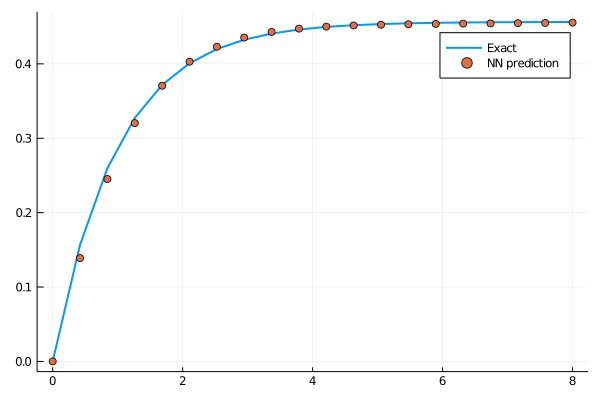

0.0069030905f0

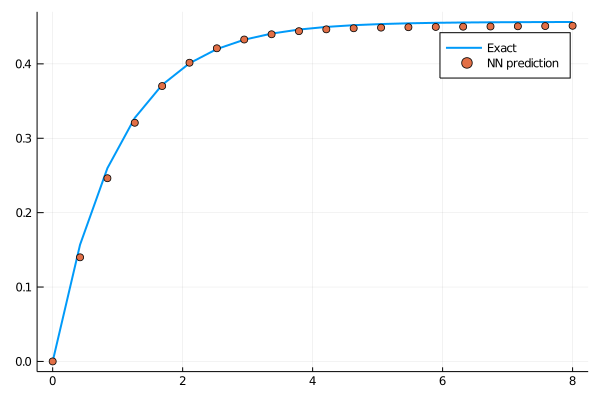

0.005604601f0

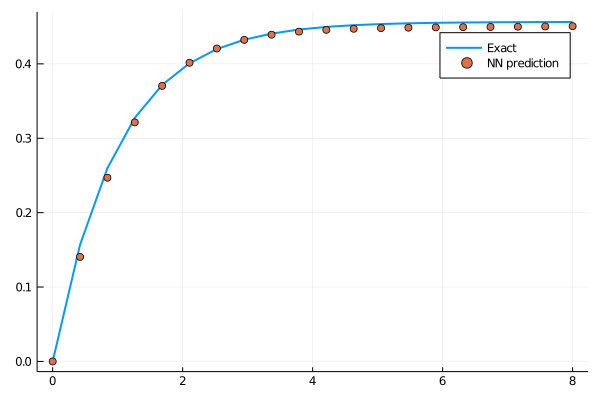

0.005203826f0

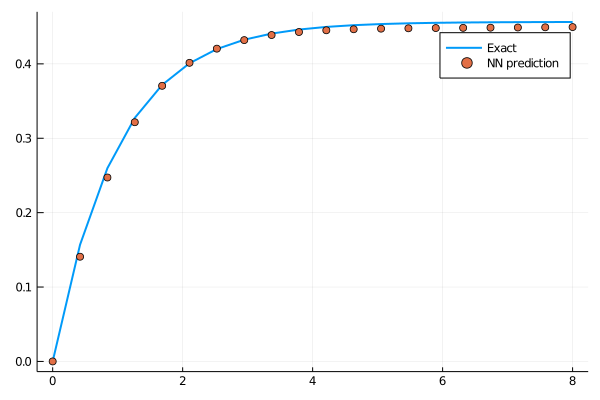

0.0049058013f0

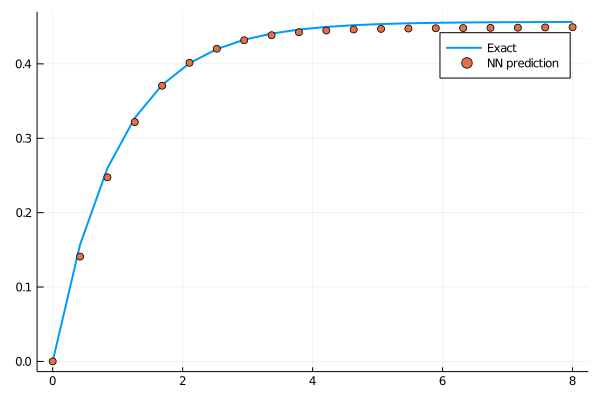

0.004568394f0

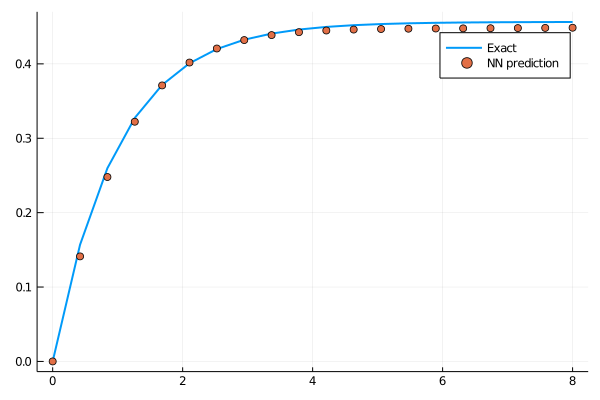

0.004243502f0

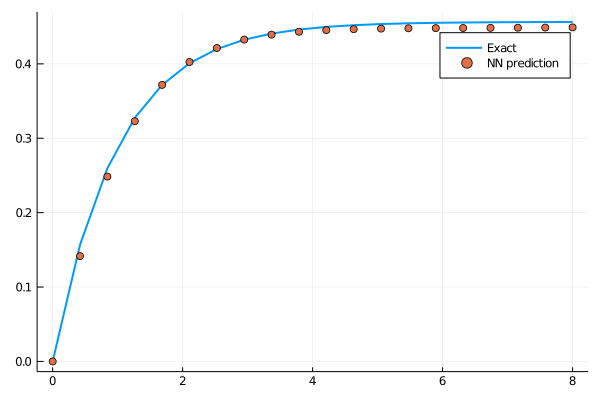

 * Status: failure

 * Candidate solution
    Minimizer: [1.03e-01, 2.98e-02, 8.21e-02,  ...]
    Minimum:   4.243502e-03

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [1.03e-01, 2.98e-02, 8.21e-02,  ...]

 * Convergence measures
    |x - x'|               = 2.13e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.02e-03 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.25e-04 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.66e-02 ≰ 0.0e+00
    |g(x)|                 = 2.32e-01 ≰ 1.0e-08

 * Work counters
    Seconds run:   19  (vs limit Inf)
    Iterations:    35
    f(x) calls:    102
    ∇f(x) calls:   102


In [18]:
res = DiffEqFlux.sciml_train(loss_n_ode, n_ode.p, ADAM(), cb=cb, maxiters=200)
res = DiffEqFlux.sciml_train(loss_n_ode, res.minimizer, LBFGS(), cb=cb, maxiters=100)

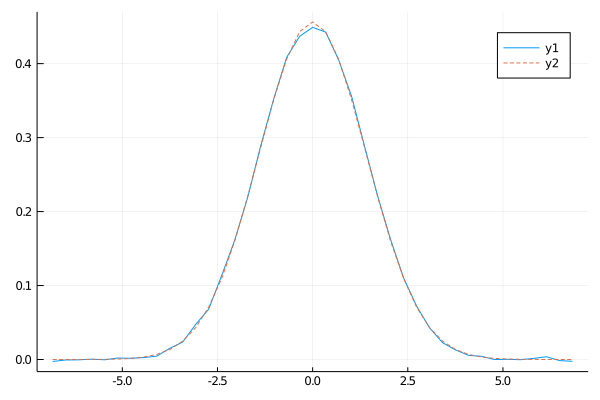

In [20]:
plot(vSpace.u, n_ode(f0, res.minimizer).u[end])
plot!(vSpace.u, ode_data[:,end], line=:dash)

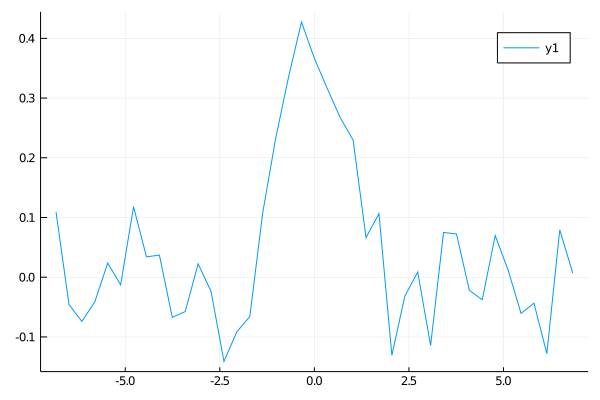

In [21]:
plot(vSpace.u, n_ode(f0./2, res.minimizer).u[end])